# Read libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from copy import copy, deepcopy
from pathlib import Path
from sys import path

path.append( str(Path.cwd().parent) )

In [2]:
import json
import re

import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
from matplotlib.gridspec import GridSpec
from numpy import arange, array, isnan
from string import punctuation, whitespace

from Project_libraries.my_stats import ( half_frame )
from Project_libraries.pubmed import ( get_time_series, plot_time_series,
                                       classify_articles, 
                                       count_articles_by_journal,
                                       get_articles_by_publisher, 
                                     )

In [60]:
folder = 'Case_brca2'
# folder = 'Case_chest_imaging_pneumonia'
# folder = 'Case_green_synthesis_silver_np'
# folder = 'Case_skin_wound_healing'

articles_file = Path.cwd() / folder / 'articles_clean.json'
png_file = Path.cwd() / folder / f"time_series.png"

catalogue_file = Path.cwd() / 'Project_libraries' / 'journal_catalogue.json'

# Load journal catalogue

In [45]:
with open(catalogue_file, 'r', encoding = 'utf-8') as file_in:
    catalogue = json.load(file_in)

In [61]:
#Check number of journals without information
#
count = 0
for journal in catalogue:
    if catalogue[journal]['publisher'] is None:
        count += 1
        
        
print(f"There are {len(catalogue)} items in the Journal Catalogue.\n\n"
      f"We lack publisher information for {count} journals.")



There are 3239 items in the Journal Catalogue.

We lack publisher information for 968 journals.


# Import articles

In [62]:
with open(articles_file, 'r', encoding = 'utf-8') as f_json:
    articles = json.load(f_json)
    
print(f"There are {len(articles)} articles in the {folder} collection.\n")
print(articles[0])

There are 9523 articles in the Case_brca2 collection.

{'retraction': None, 'journal': 'Adv Exp Med Biol', 'year': 2020, 'date': '', 'volume': '1292', 'pages': '1-12', 'doi': '10.1007/5584_2018_147', 'title': 'The BRCA1 and BRCA2 Genes in Early-Onset Breast Cancer Patients.', 'authors': 'Saleem M(1)(2), Ghazali MB(1)(3), Wahab MAMA(1), Yusoff NM(1), Mahsin H(4), Seng CE(5), Khalid IA(3), Rahman MNG(6), Yahaya BH(7)', 'affiliations': 'Author information: (1)Regenerative Medicine Cluster, Advanced Medical and Dental Institute, Universiti Sains Malaysia, Penang, Malaysia. (2)Genomix Lab Sdn Bhd, Petaling Jaya, Selangor, Malaysia. (3)Surgery Department, Seberang Jaya Hospital, Seberang Prai, Malaysia. (4)Pathology Department, Seberang Jaya Hospital, Seberang Prai, Malaysia. (5)Oncology and Radiological Sciences Cluster, Advanced Medical and Dental Institute, Universiti Sains Malaysia, Penang, Malaysia. (6)Surgery Department, School of Medical Sciences, Universiti Sains Malaysia, Kubang Ker

In [63]:
print(f"We are verifying publisher information for {len(articles)} articles.\n")

no_info = []
for i, article in enumerate( articles ):
    journal = article['journal']
    
    journal_info = catalogue[journal]
    
    # We lack info for some journals
#     if journal_info is None:
#         no_info.append(i)
#         for key in ['publisher', 'start_date', 'mesh']:
#             article[key] = None
            
#         continue
    
#     el
    if journal_info['publisher'] is None:
        no_info.append(i)
        for key in ['publisher', 'start_date', 'mesh']:
            article[key] = None

        continue
    
    for key in ['publisher', 'start_date', 'mesh']:
        if key not in journal_info.keys():
            article[key] = None
        else:
            article[key] = journal_info[key]
        
    
print(f"Finished processing all articles.\n\n"
      f"We lack publisher information for {len(no_info)} articles.")



We are verifying publisher information for 9523 articles.

Finished processing all articles.

We lack publisher information for 1433 articles.


## Calculate breakdown by publisher

In [64]:
publishers = []
for article in articles:
    if 'publisher' in article.keys():
        publishers.append( article['publisher'] )
    
counter = Counter(publishers)

counter.most_common(20)

[('Springer Nature', 2226),
 ('Elsevier', 1550),
 (None, 1433),
 ('Wiley', 972),
 ('American Association for Cancer Research', 427),
 ('Oxford University Press', 329),
 ('MDPI', 260),
 ('American Society of Clinical Oncology', 217),
 ('Taylor & Francis', 212),
 ('Wolters Kluwer', 203),
 ('PLoS', 188),
 ('British Medical Association', 135),
 ('Frontiers', 121),
 ('Hindawi', 119),
 ('Cell Press', 111),
 ('Spandidos', 98),
 ('American Medical Association', 84),
 ('Karger', 75),
 ('Sage', 64),
 ('Mary Ann Liebert', 51)]

In [65]:
catalogue['Molecules']

{'last_publisher_note': None,
 'publisher_note': None,
 'cr_note': None,
 'publisher': 'MDPI'}

In [66]:
count_articles_by_journal(get_articles_by_publisher(articles, None), 30)

[('Oncotarget', 104),
 ('Oncogene', 52),
 ('Psychooncology', 41),
 ('Asian Pac J Cancer Prev', 37),
 ('Cell Cycle', 35),
 ('Breast Cancer', 34),
 ('Klin Onkol', 30),
 ('N Engl J Med', 26),
 ('Obstet Gynecol', 22),
 ('J Natl Compr Canc Netw', 22),
 ('Prostate', 20),
 ('Cancer Res Treat', 19),
 ('Clin Adv Hematol Oncol', 18),
 ('Maturitas', 18),
 ('Nihon Rinsho', 18),
 ('Gan To Kagaku Ryoho', 17),
 ('Clin Transl Oncol', 16),
 ('BJOG', 15),
 ('Neoplasma', 14),
 ('J Gynecol Oncol', 14),
 ('J BUON', 11),
 ('Minerva Ginecol', 11),
 ('J Cell Biol', 11),
 ('Clin J Oncol Nurs', 10),
 ('Ginekol Pol', 10),
 ('Virchows Arch', 10),
 ('Oncol Nurs Forum', 10),
 ('Curr Treat Options Oncol', 9),
 ('Curr Oncol Rep', 9),
 ('Public Health Genomics', 9)]

# Analyze trends relating to review articles

In [52]:
pattern1 = 'review'
pattern2 = 'reviewed'

# Full set 
#
output = classify_articles( articles, 'FULL' )
no_abstract_all, retracted_all, erratum_all, commented_all = output

# Review articles set
#
review_articles = []
for article in articles:
    if article['abstract']:
        if ( pattern1 in article['abstract'].lower() 
             or pattern2 in article['abstract'].lower() ):
            review_articles.append( article )

output = classify_articles( review_articles, 'REVIEW' )
no_abstract_review, retracted_review, erratum_review, commented_review = output


# No review articles set
#
no_review_articles = []
for article in articles:
    if article['abstract']:
        if not ( pattern1 in article['abstract'].lower() 
                 or pattern2 in article['abstract'].lower() ):
            no_review_articles.append( article )

output = classify_articles( no_review_articles, 'NO REVIEW' )
no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output


There are 8388 articles in the FULL set; 298 have no abstract; 
17 have been retracted; 100 have had errata published; and 
3 have had comments written about them.


There are 1467 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 22 have had errata published; and 
1 have had comments written about them.


There are 6623 articles in the NO REVIEW set; 0 have no abstract; 
17 have been retracted; 75 have had errata published; and 
2 have had comments written about them.




## Create dataframe with time series 

In [53]:
year0, year1 = 2000, 2024
# year0, year1 = 2006, 2021


df_time_series = pd.DataFrame( {'Year': array(range(year0, year1)), 
                                'Full Set Papers': get_time_series(pd.DataFrame(articles), year0, year1),
                                'FS Retracted': get_time_series(pd.DataFrame(retracted_all), year0, year1), 
                                'FS Errata': get_time_series(pd.DataFrame(erratum_all), year0, year1),
                                'FS Comments': get_time_series(pd.DataFrame(commented_all), year0, year1),
                                'Review Papers': get_time_series(pd.DataFrame(review_articles), year0, year1),
                                'Rev Retracted': get_time_series(pd.DataFrame(retracted_review), year0, year1), 
                                'Rev Errata': get_time_series(pd.DataFrame(erratum_review), year0, year1),
                                'Rev Comments': get_time_series(pd.DataFrame(commented_review), year0, year1),
                                'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                                'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                                'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                                'NoRev Comments': get_time_series(pd.DataFrame(commented_norev), year0, year1),
                               } )

df_time_series



Year  Full Set Papers  FS Retracted  FS Errata  FS Comments  \
0   2000              103             0          2            0   
1   2001               86             0          0            0   
2   2002               97             0          0            0   
3   2003               99             0          1            0   
4   2004              123             0          1            0   
5   2005              130             0          0            1   
6   2006              118             0          5            0   
7   2007              124             0          0            0   
8   2008              146             0          1            0   
9   2009              134             0          0            0   
10  2010              139             0          1            0   
11  2011              166             0          1            0   
12  2012              167             0          1            0   
13  2013              158             0          0            0   
14  2014              184             0          1            0   
15  2015              185             0          3            0   
16  2016              190             0          2            0   
17  2017              212             0          4            0   
18  2018              243             0          3            0   
19  2019              280             0          5            0   
20  2020             1441             2         21            0   
21  2021             1746             4         22            0   
22  2022             1221            10         15            1   
23  2023              853             1         11            1   

    Review Papers  Rev Retracted  Rev Errata  Rev Comments  No Review Papers  \
0              22            NaN           1             0                75   
1              20            NaN           0             0                60   
2              21            NaN           0             0                65   
3              13            NaN           0             0                78   
4              23            NaN           0             0                91   
5              30            NaN           0             0                95   
6              22            NaN           0             0                90   
7              27            NaN           0             0                94   
8              24            NaN           0             0               115   
9              29            NaN           0             0                99   
10             26            NaN           1             0               103   
11             28            NaN           0             0               133   
12             40            NaN           1             0               122   
13             30            NaN           0             0               125   
14             30            NaN           0             0               147   
15             41            NaN           1             0               138   
16             48            NaN           1             0               133   
17             51            NaN           1             0               152   
18             47            NaN           1             0               185   
19             52            NaN           1             0               217   
20            255            NaN           7             0              1108   
21            280            NaN           4             0              1426   
22            176            NaN           3             0              1027   
23            124            NaN           0             1               712   

    NoRev Retracted  NoRev Errata  NoRev Comments  
0                 0             1               0  
1                 0             0               0  
2                 0             0               0  
3                 0             1               0  
4                 0             1               0  
5              

## Calculate ratios

In [54]:
key = 'Review Papers'
column = f"{key}_ratio"
df_time_series[column] = df_time_series[key] / df_time_series['Full Set Papers']
    
for key in [ 'NoRev Retracted', 'NoRev Errata', 'NoRev Comments' ]:
    column = f"{key}_ratio"
    df_time_series[column] = df_time_series[key] / df_time_series['No Review Papers']


## Plot data

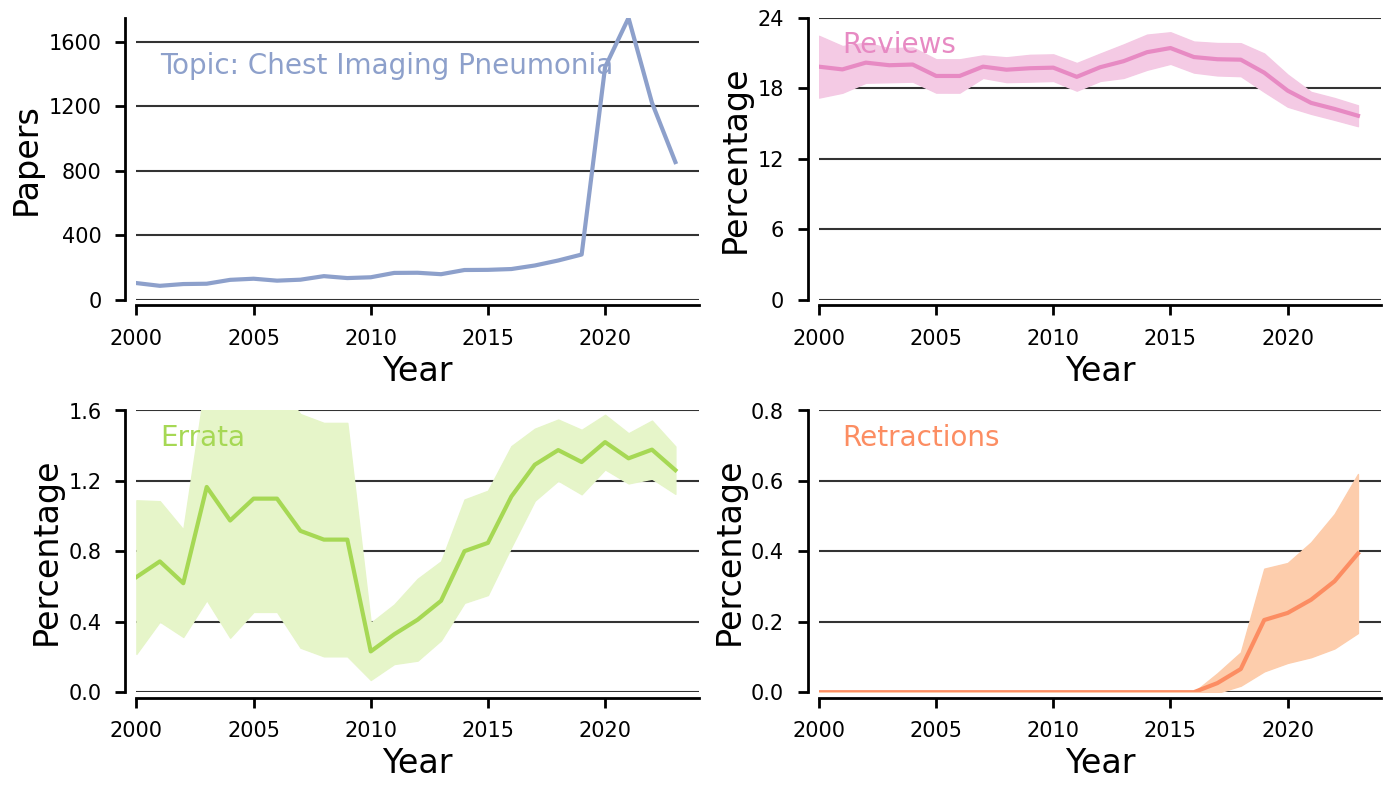

In [55]:
colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
           'Errata': '#a6d854', 'Comments': '#66c2a5', }

colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
             'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

fig = plt.figure( figsize = (14, 8) )
ax = []

#print(f"--{folder.replace('_', ' ')}--")
ax.append(fig.add_subplot(221))
plot_time_series( ax[-1], df_time_series, 'Full Set Papers', 1, 
                         folder.replace('_', ' '), colors['Papers'], 
                         colors_b['Papers'] )

ax.append(fig.add_subplot(222))
plot_time_series( ax[-1], df_time_series, 'Review Papers_ratio', 7, 
                        'Reviews', colors['Reviews'], 
                        colors_b['Reviews'] )

ax.append(fig.add_subplot(224))
plot_time_series( ax[-1], df_time_series, 'NoRev Retracted_ratio', 7, 
                        'Retractions', colors['Retracted'], 
                        colors_b['Retracted'] )

ax.append(fig.add_subplot(223))
# plot_time_series( ax[-1], df_time_series, 'NoRev Comments_ratio', 5, 
#                          'Comments', colors['Comments'], 
#                         colors_b['Comments'] )

plot_time_series( ax[-1], df_time_series, 'NoRev Errata_ratio', 7, 
                        'Errata', colors['Errata'], 
                        colors_b['Errata'] )

plt.tight_layout()

plt.savefig(png_file)

# Analyze trends by journal


There are 132 articles in the set for PLoS One
There are 132 articles in the FULL set; 0 have no abstract; 
1 have been retracted; 3 have had errata published; and 
0 have had comments written about them.


There are 21 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 1 have had errata published; and 
0 have had comments written about them.


There are 111 articles in the NO REVIEW set; 0 have no abstract; 
1 have been retracted; 2 have had errata published; and 
0 have had comments written about them.



There are 73 articles in the set for Radiology
There are 73 articles in the FULL set; 11 have no abstract; 
0 have been retracted; 6 have had errata published; and 
0 have had comments written about them.


There are 26 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 2 have had errata published; and 
0 have had comments written about them.


There are 36 articles in the NO REVIEW set; 0 have no abstract; 
0 have been retracted; 2 have ha


There are 80 articles in the set for Comput Biol Med
There are 80 articles in the FULL set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
0 have had comments written about them.


There are 4 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
0 have had comments written about them.


There are 76 articles in the NO REVIEW set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
0 have had comments written about them.



There are 31 articles in the set for Front Med (Lausanne)
There are 31 articles in the FULL set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
0 have had comments written about them.


There are 3 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
0 have had comments written about them.


There are 28 articles in the NO REVIEW set; 0 have no abstract; 
0 have been retracte

/var/folders/kg/0vy46x448xj0yq006s7c5hy80000gn/T/ipykernel_83937/334534032.py:78: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure( figsize = (14, 8) )



There are 35 articles in the set for Sensors (Basel)
There are 35 articles in the FULL set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
0 have had comments written about them.


There are 1 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
0 have had comments written about them.


There are 34 articles in the NO REVIEW set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
0 have had comments written about them.



There are 68 articles in the set for Clin Imaging
There are 68 articles in the FULL set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
0 have had comments written about them.


There are 22 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
0 have had comments written about them.


There are 46 articles in the NO REVIEW set; 0 have no abstract; 
0 have been retracted; 0 ha


There are 45 articles in the set for Curr Med Imaging
There are 45 articles in the FULL set; 1 have no abstract; 
0 have been retracted; 0 have had errata published; and 
0 have had comments written about them.


There are 7 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
0 have had comments written about them.


There are 37 articles in the NO REVIEW set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
0 have had comments written about them.



There are 55 articles in the set for BMC Pulm Med
There are 55 articles in the FULL set; 0 have no abstract; 
0 have been retracted; 2 have had errata published; and 
0 have had comments written about them.


There are 9 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
0 have had comments written about them.


There are 46 articles in the NO REVIEW set; 0 have no abstract; 
0 have been retracted; 2 ha

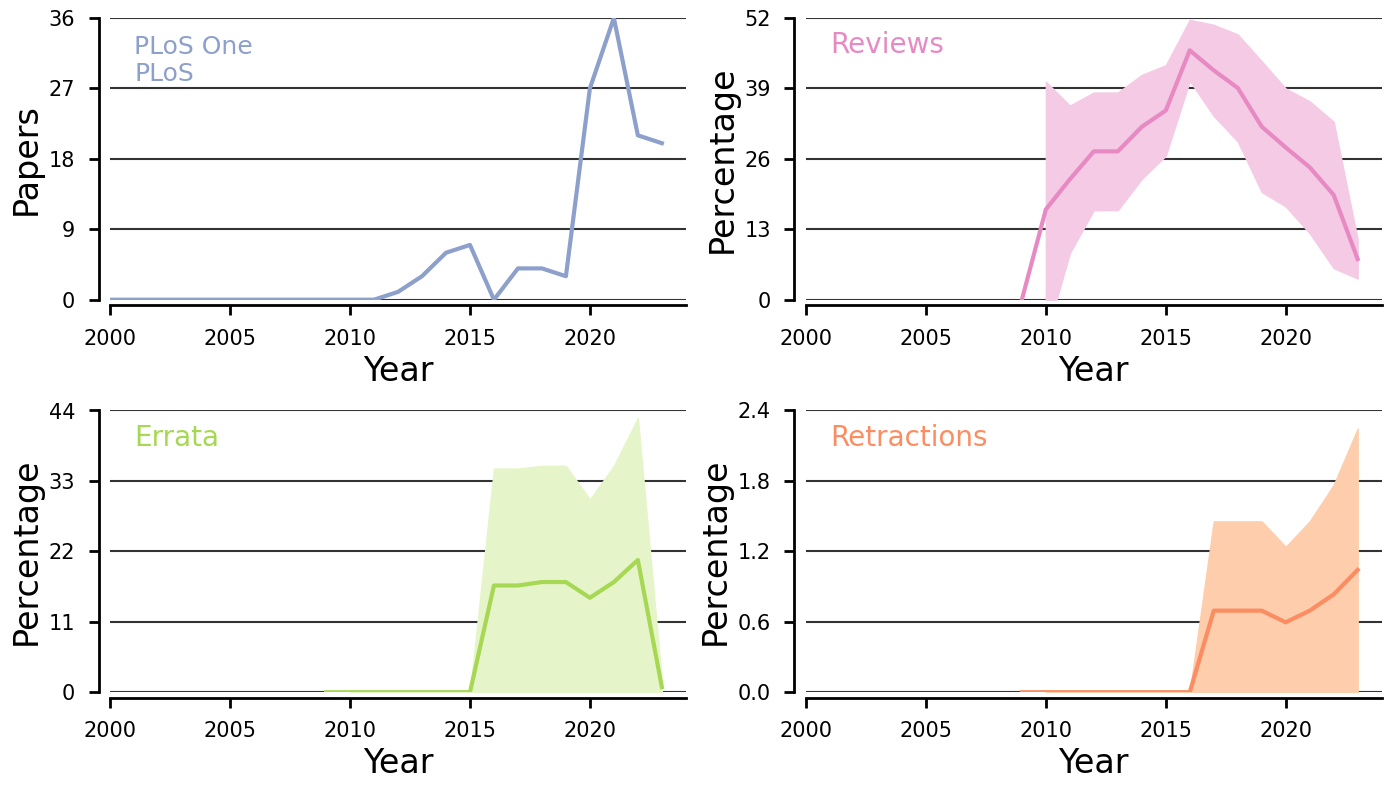

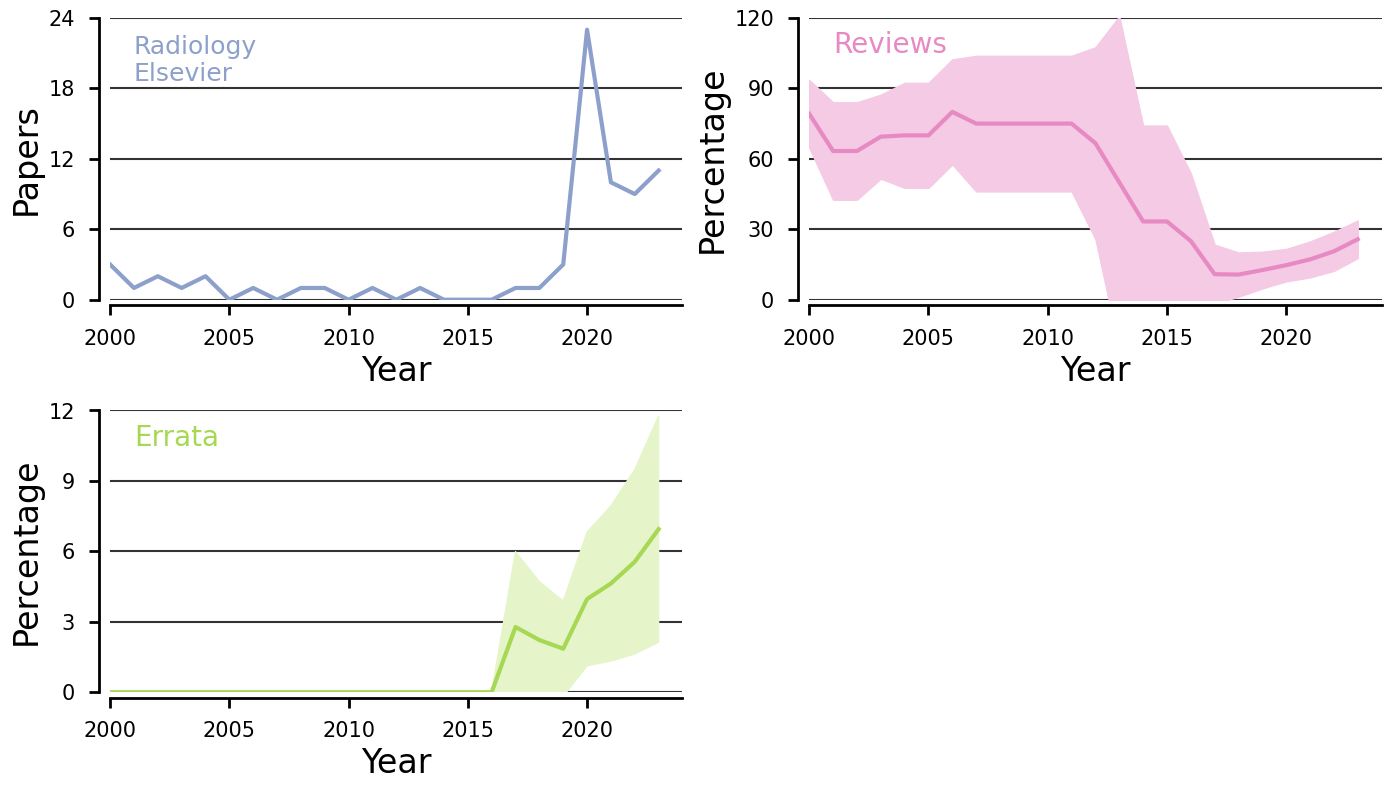

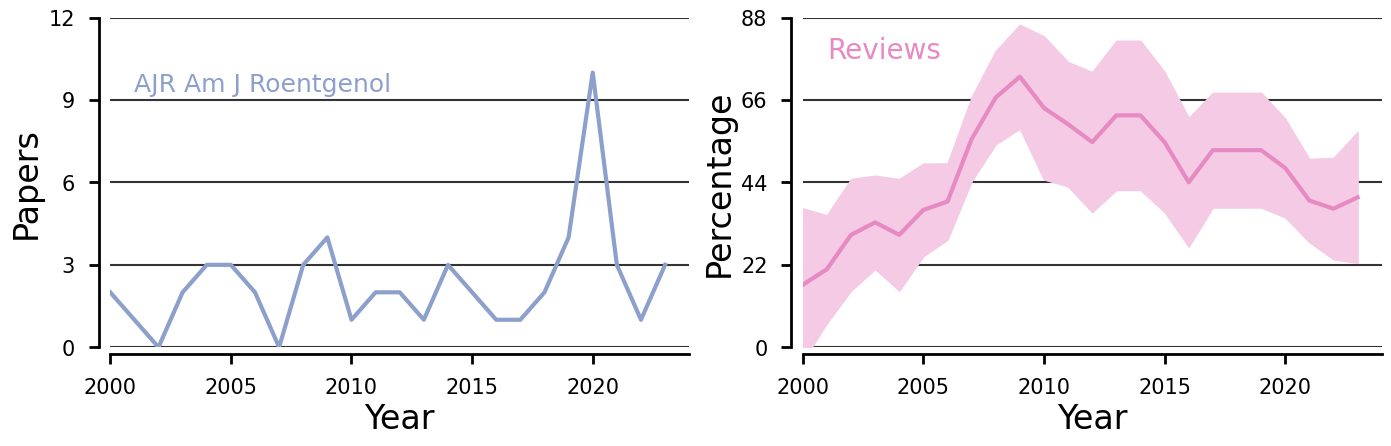

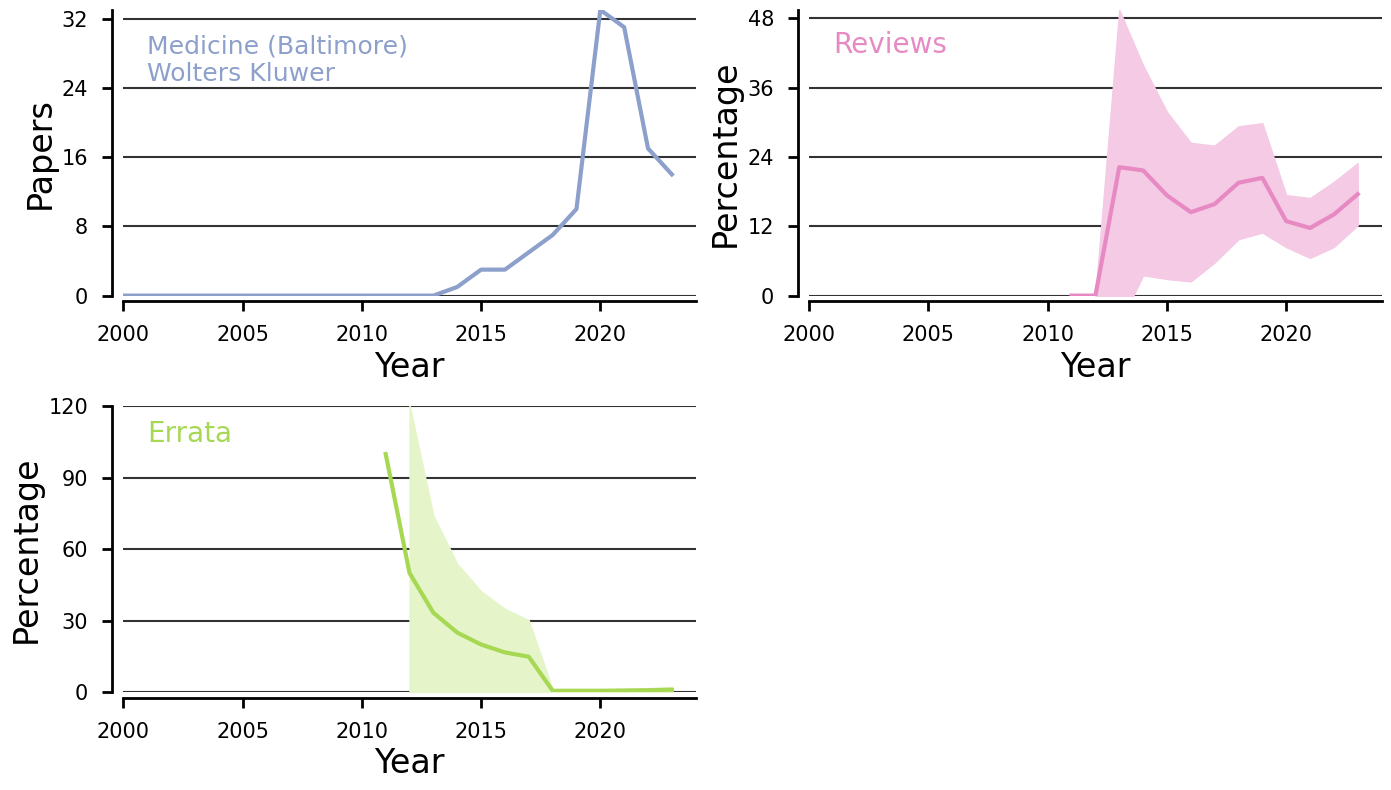

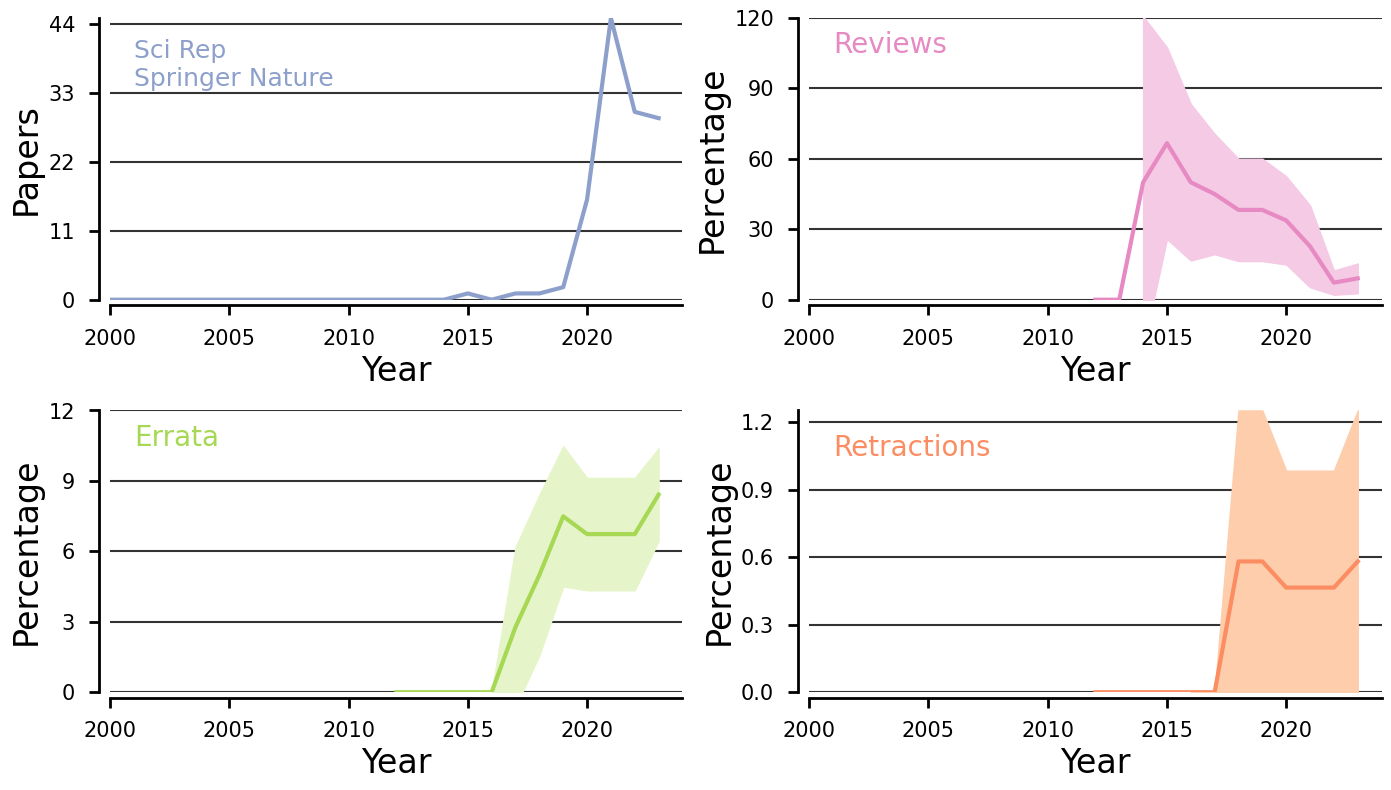

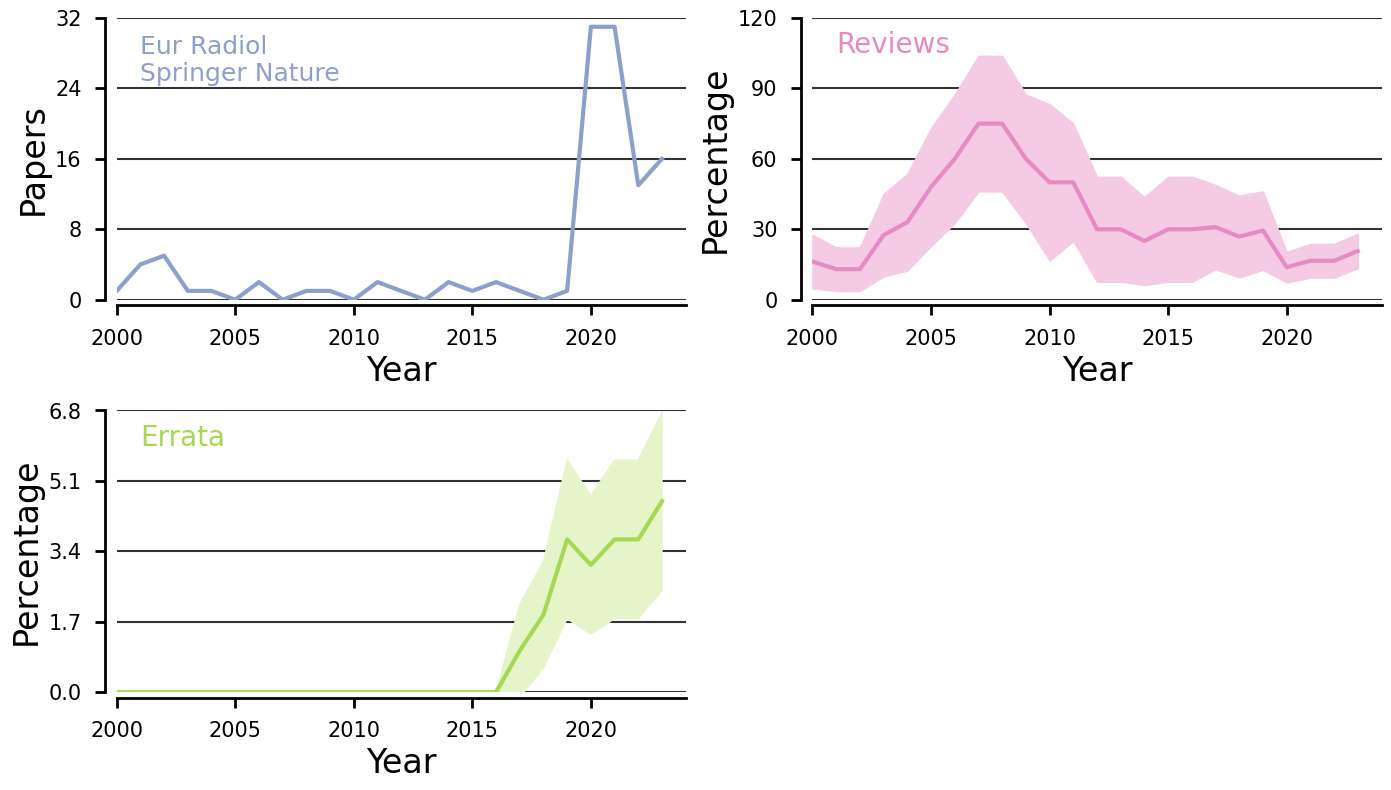

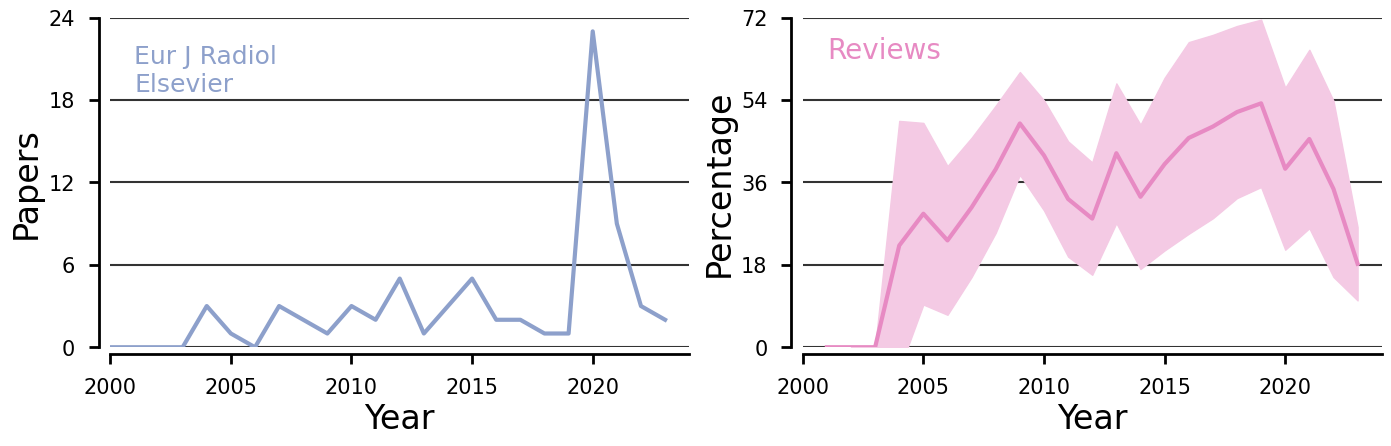

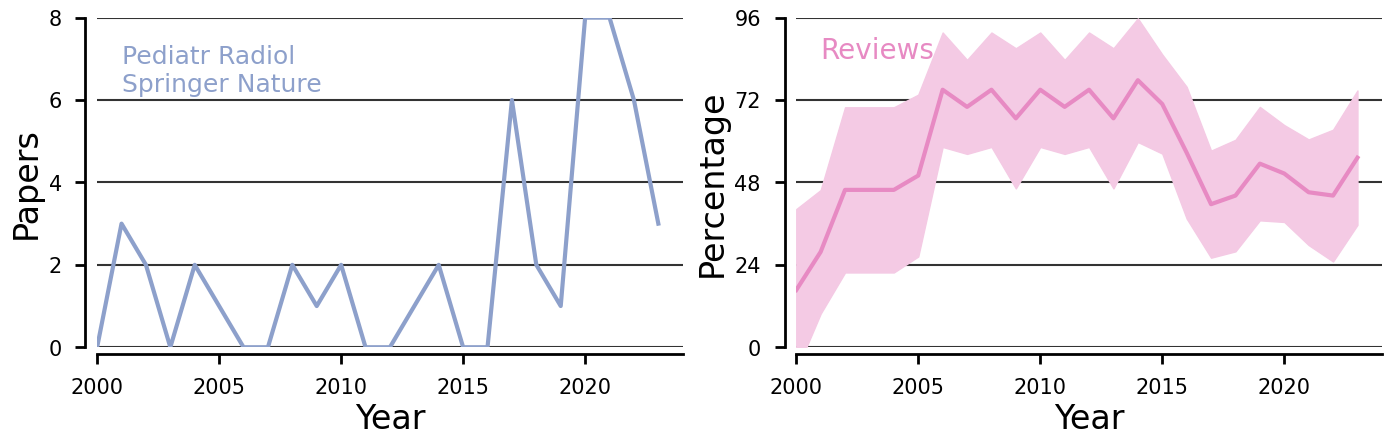

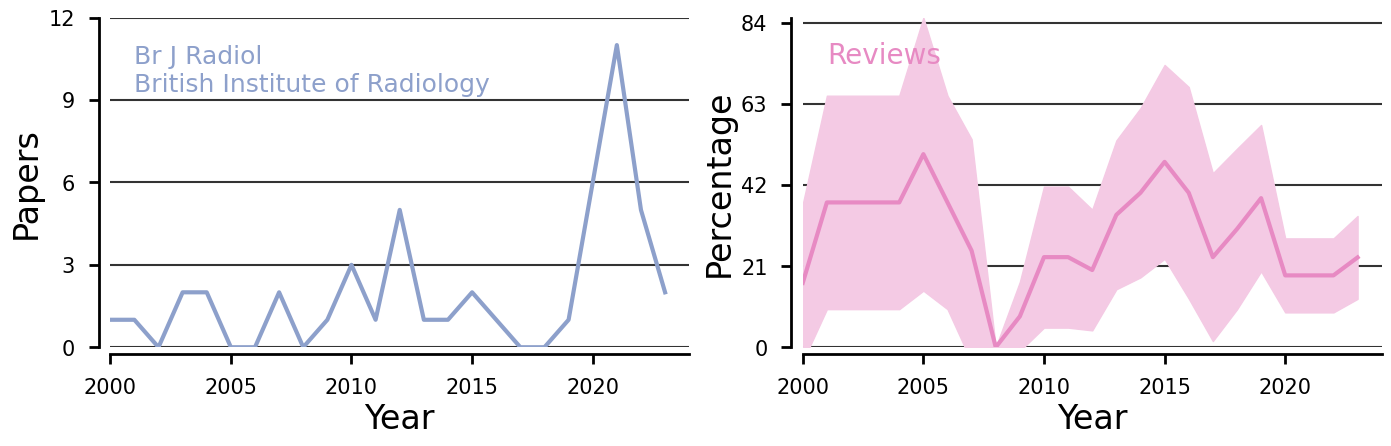

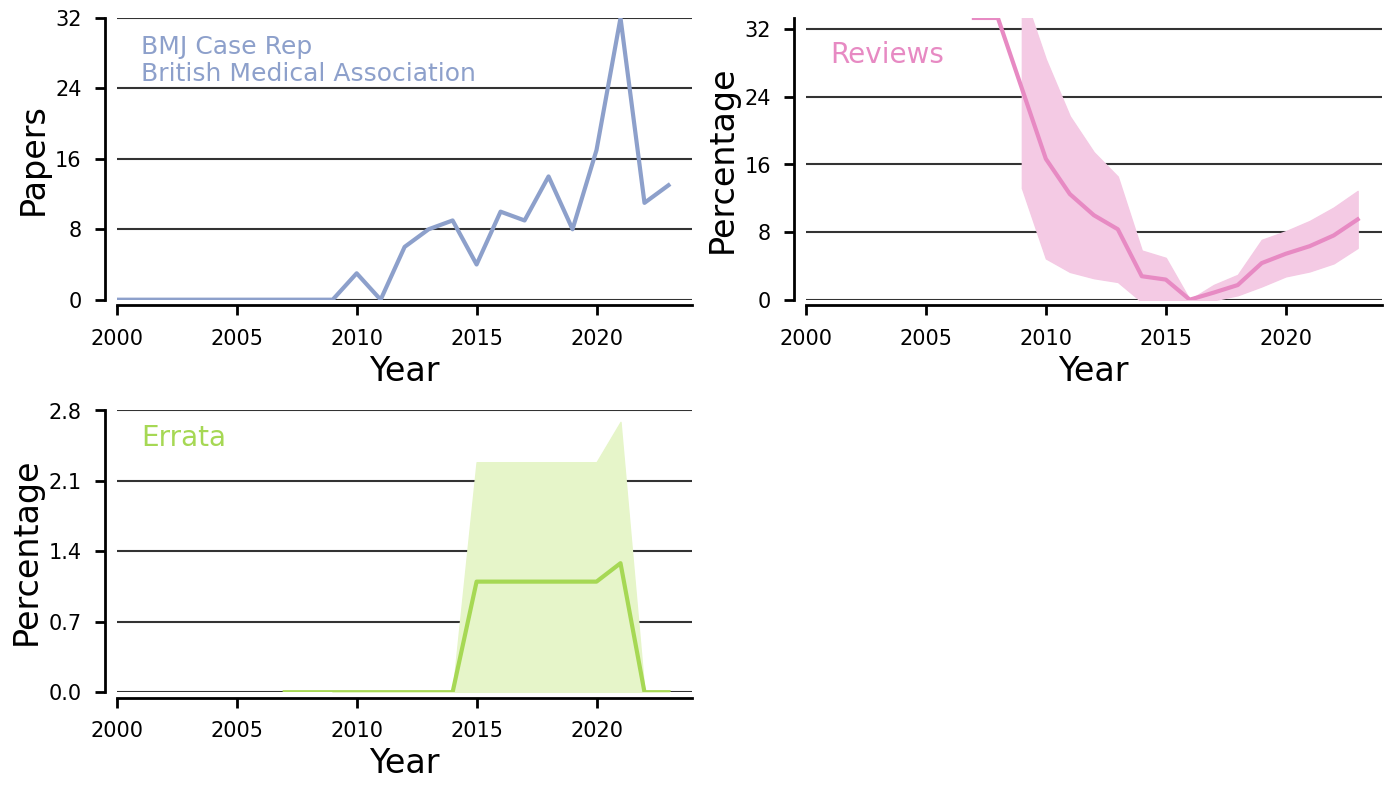

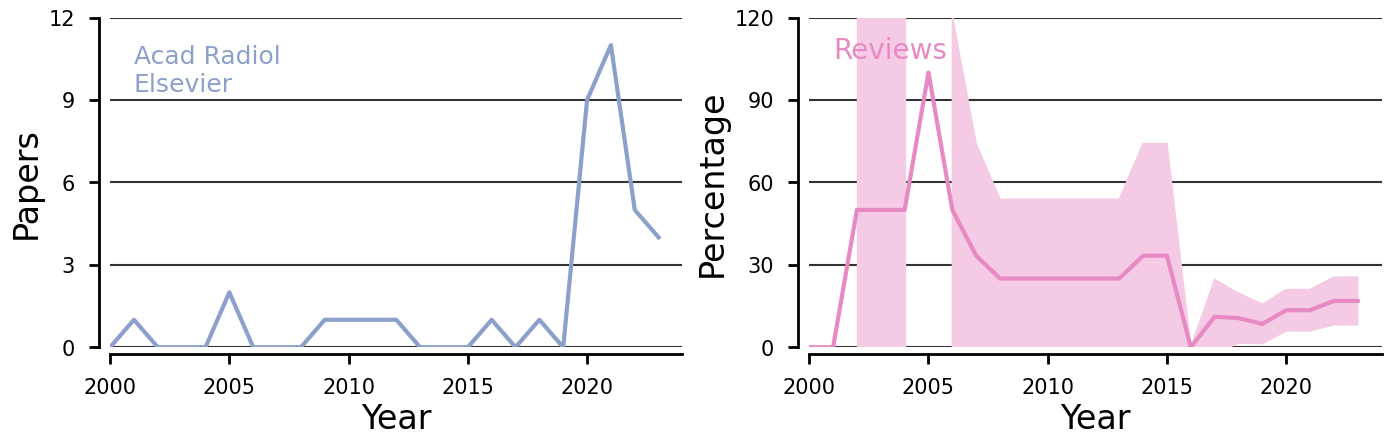

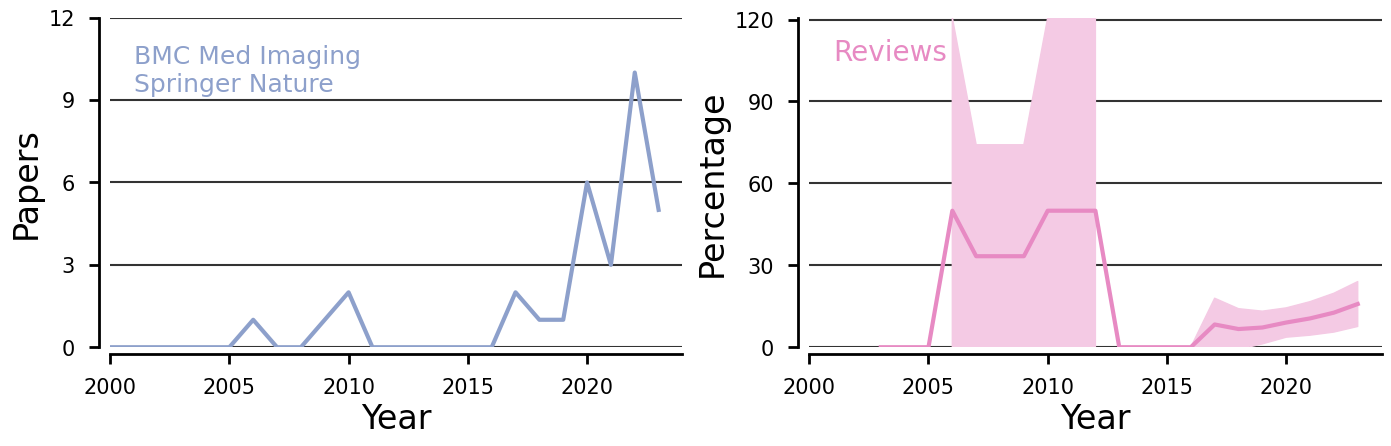

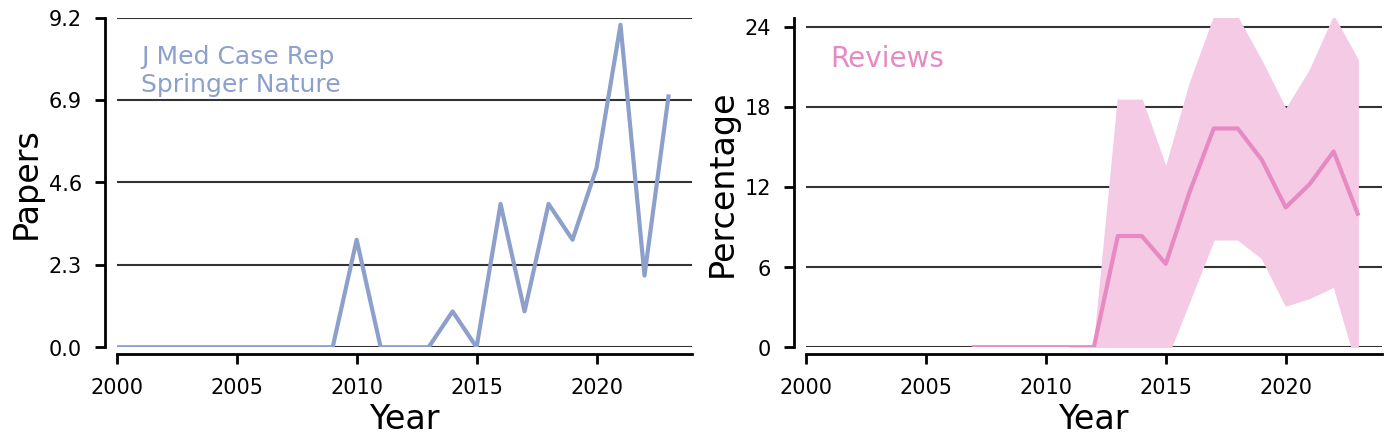

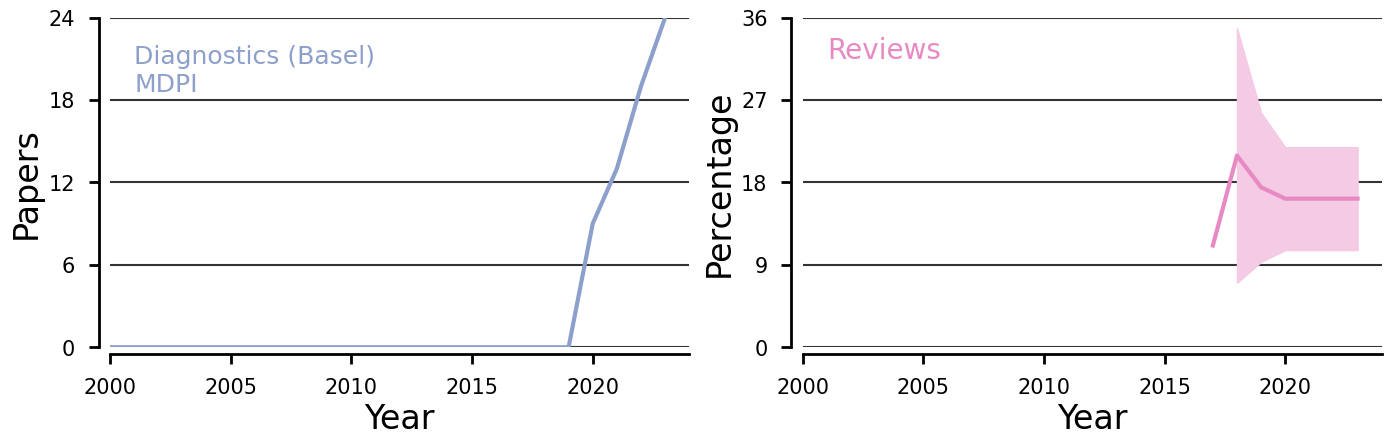

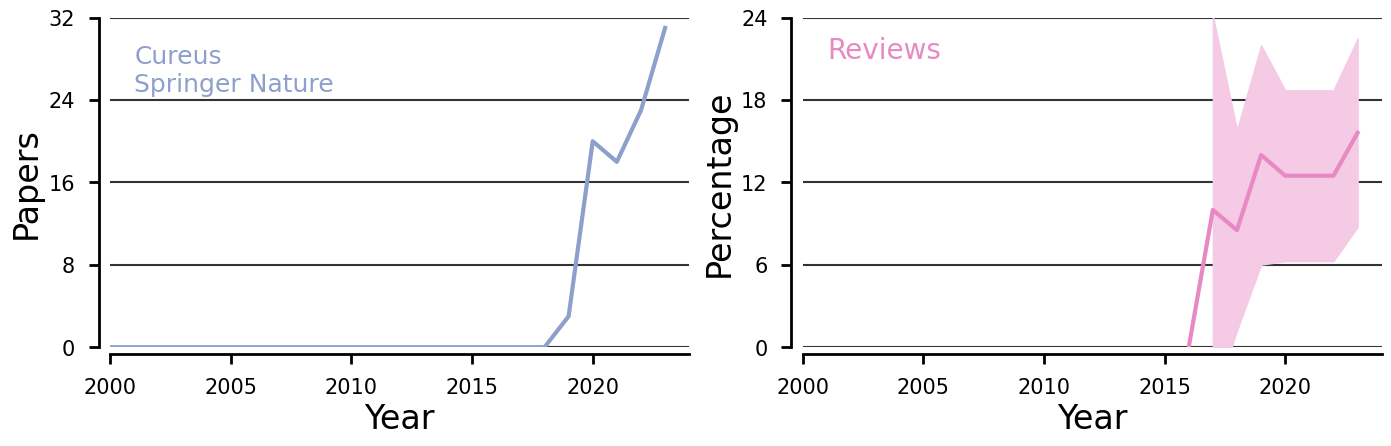

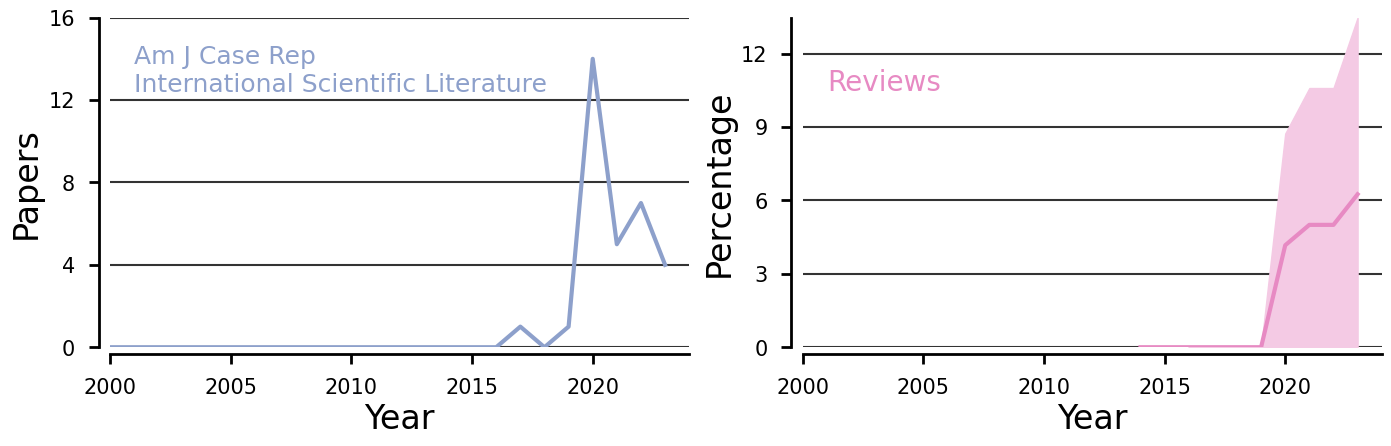

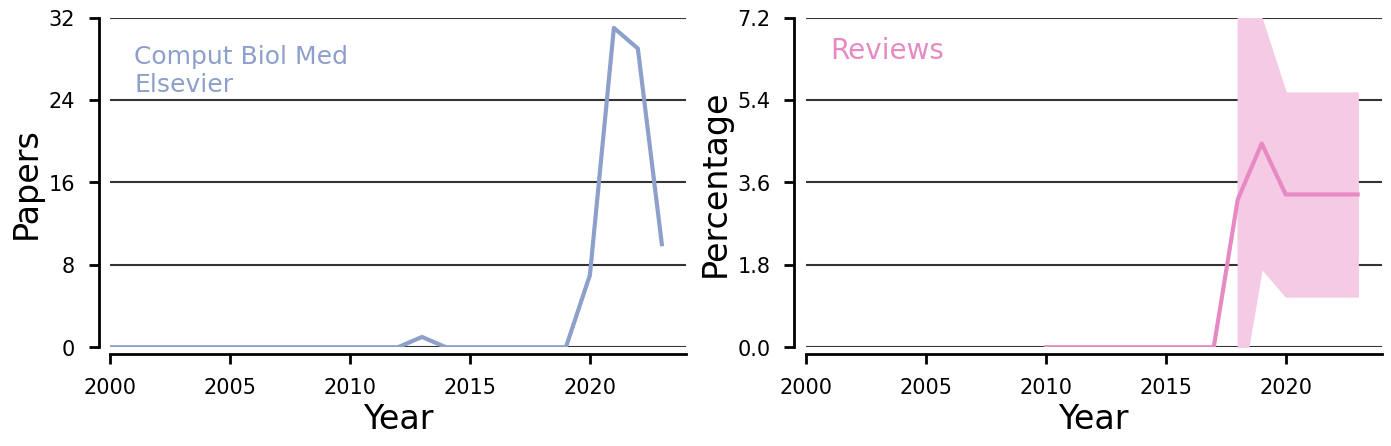

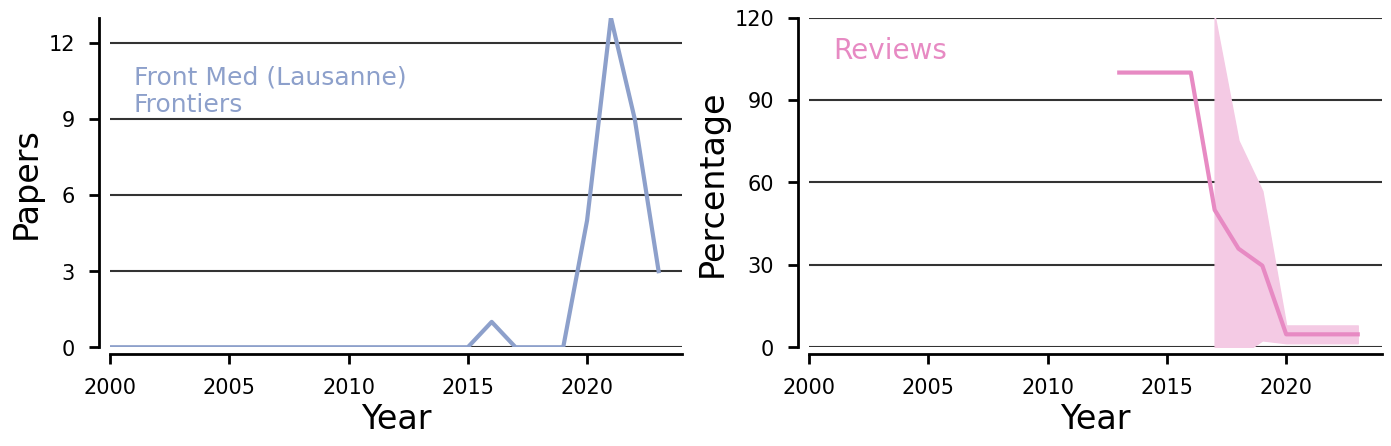

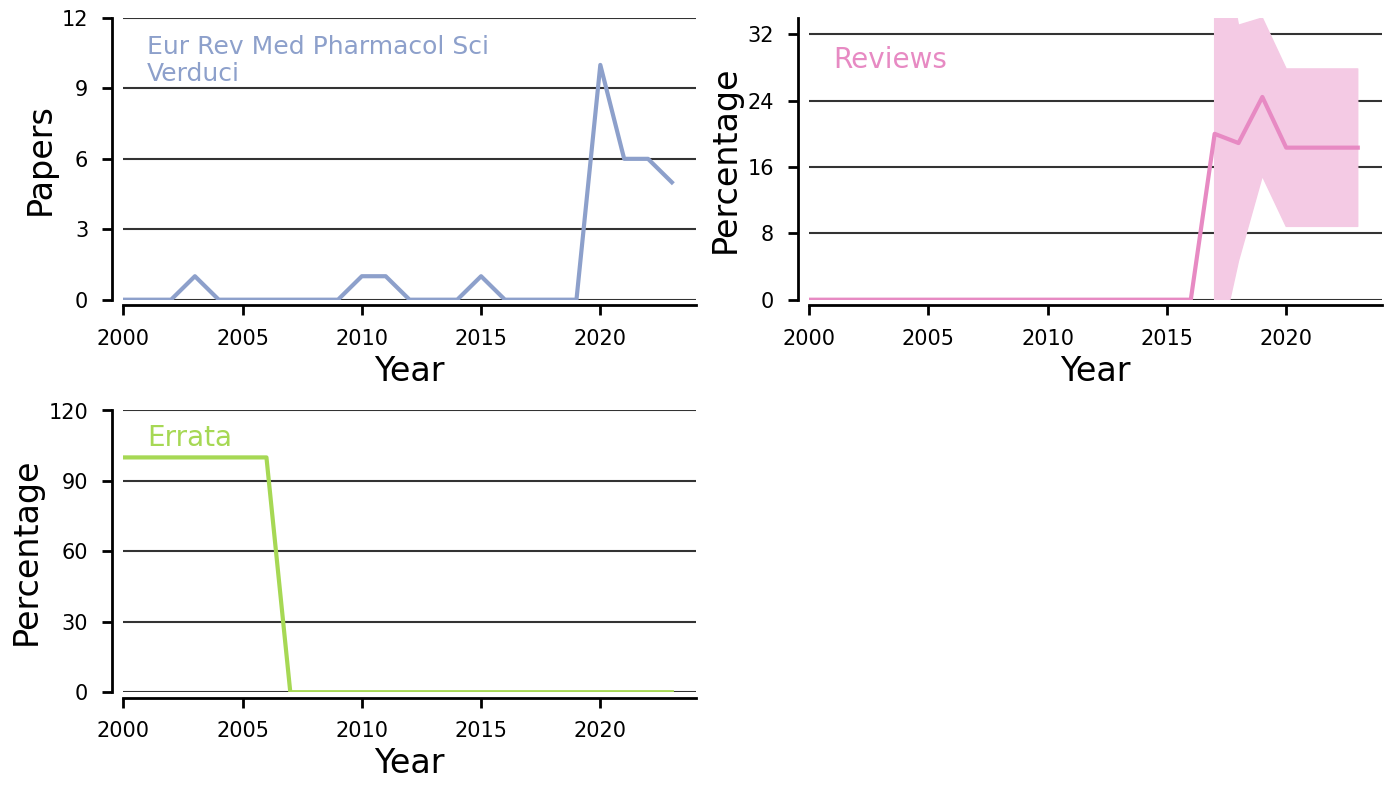

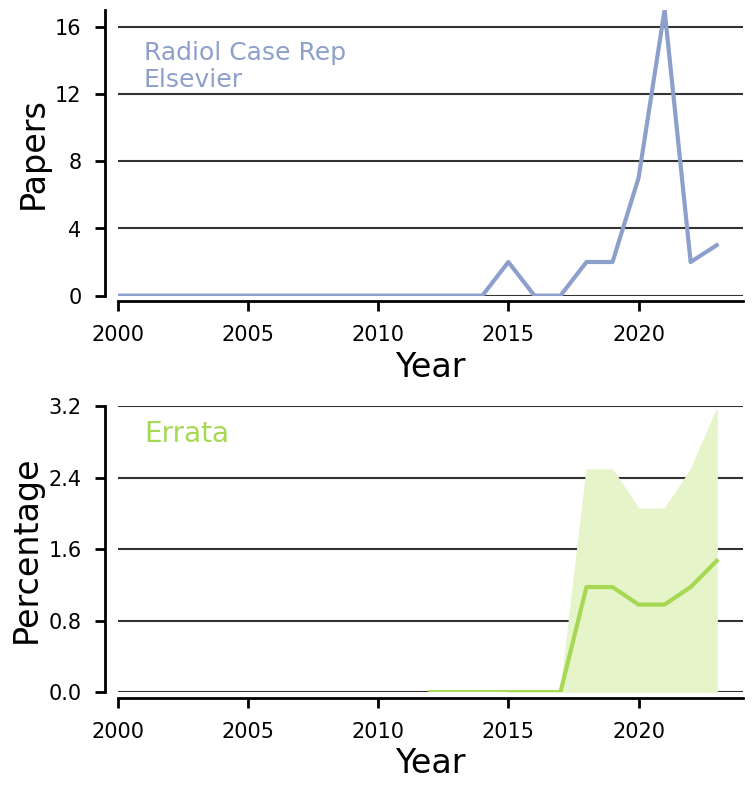

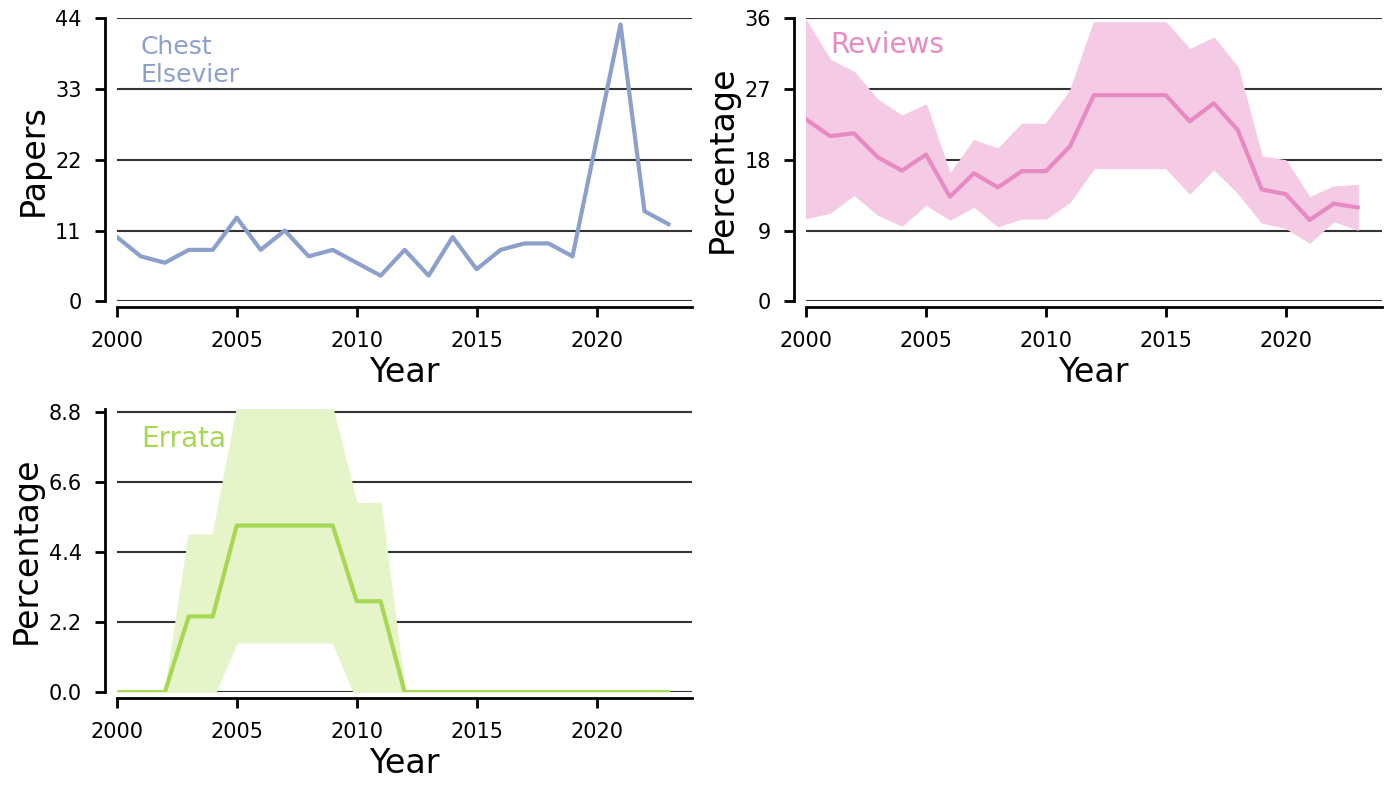

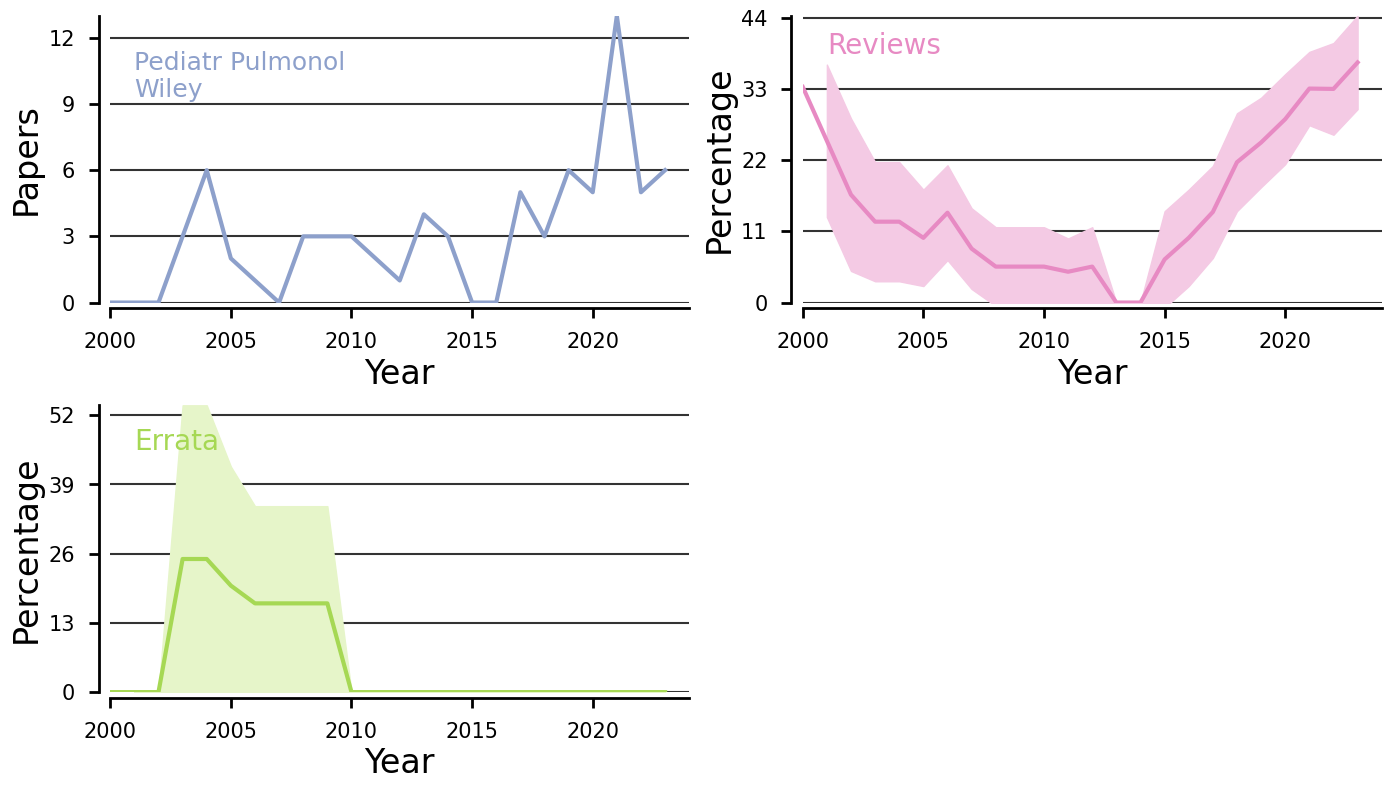

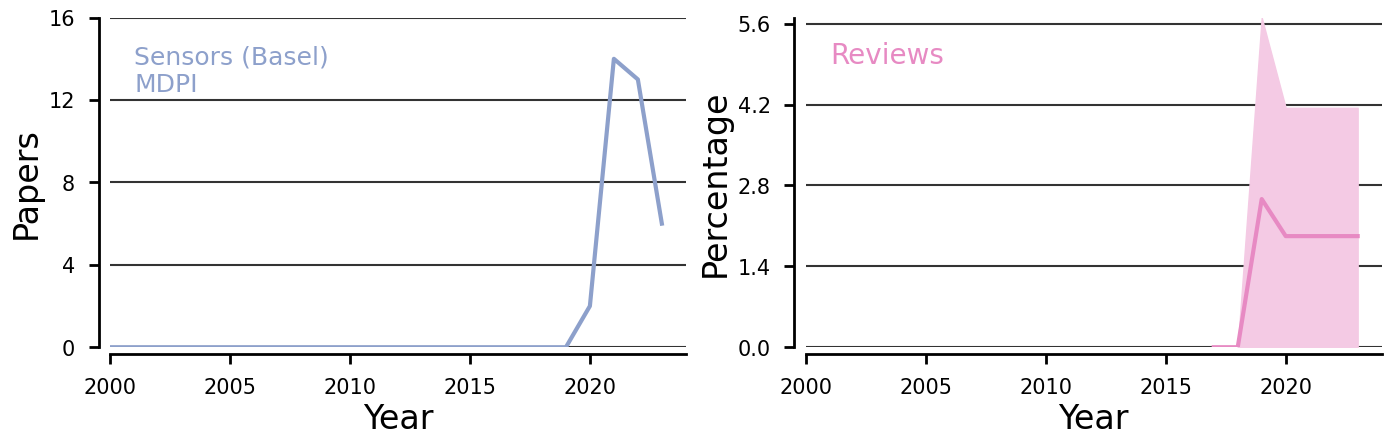

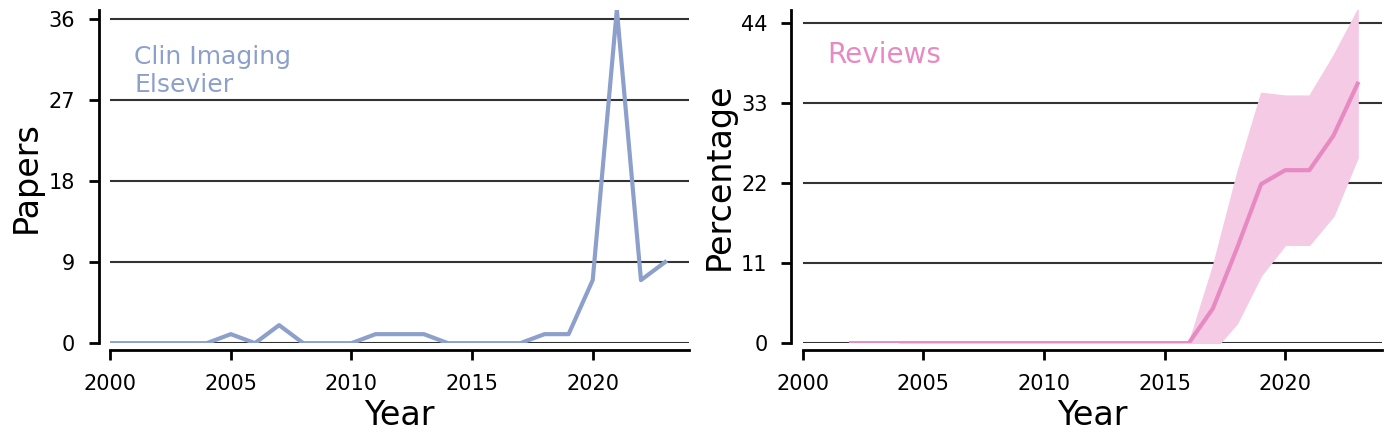

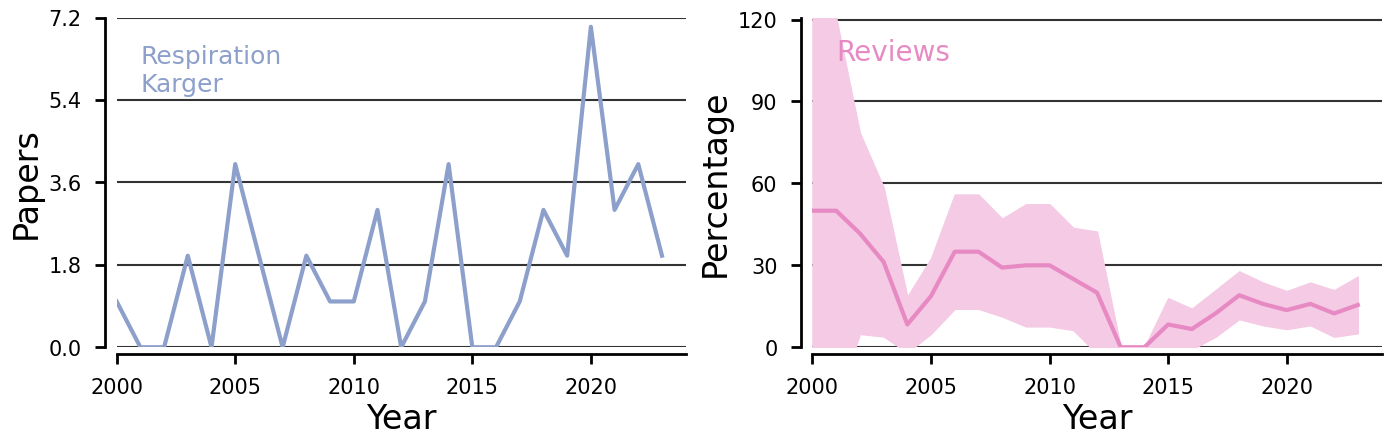

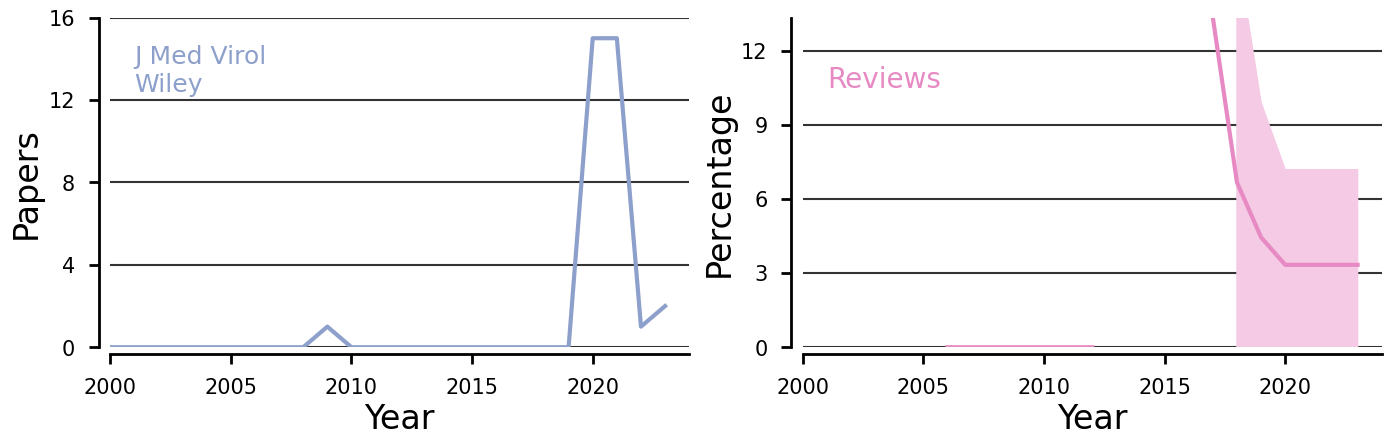

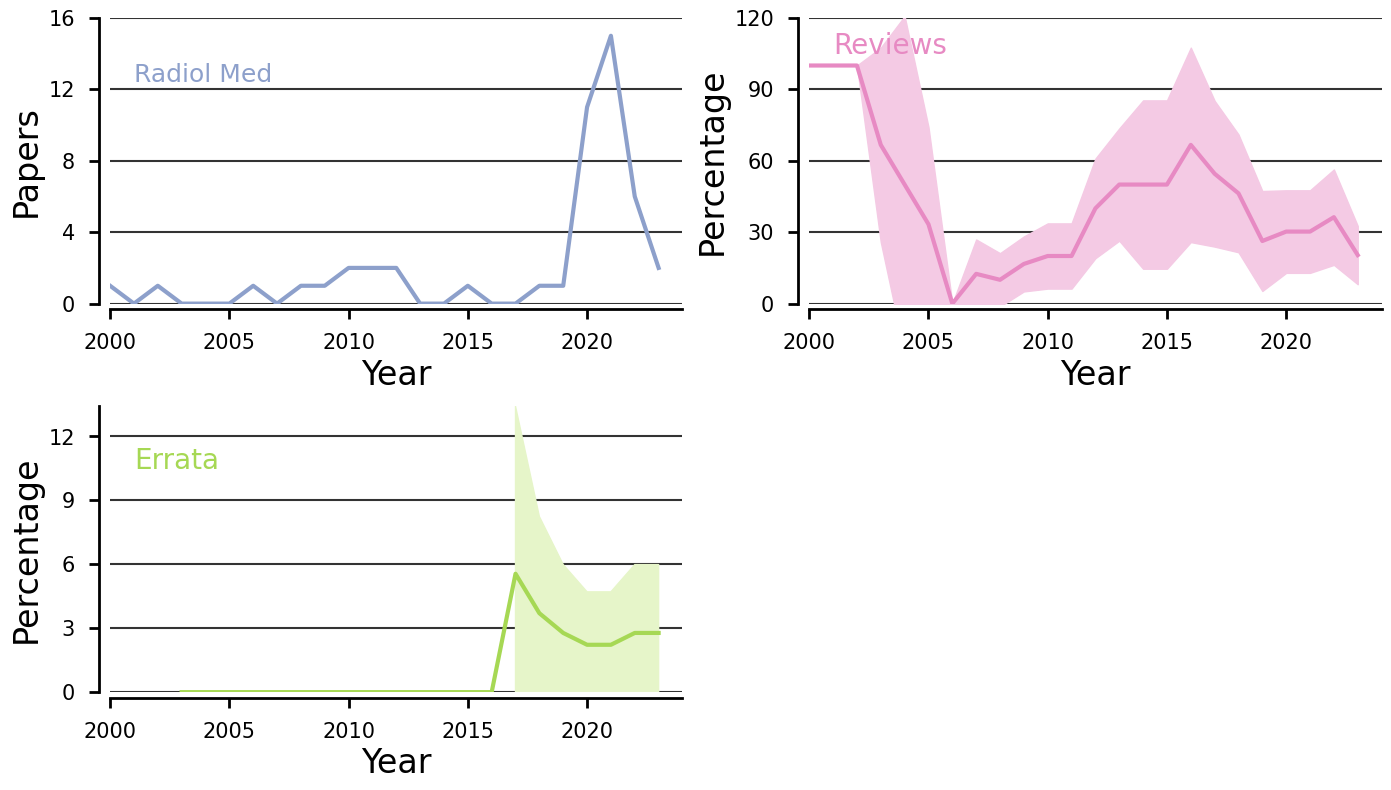

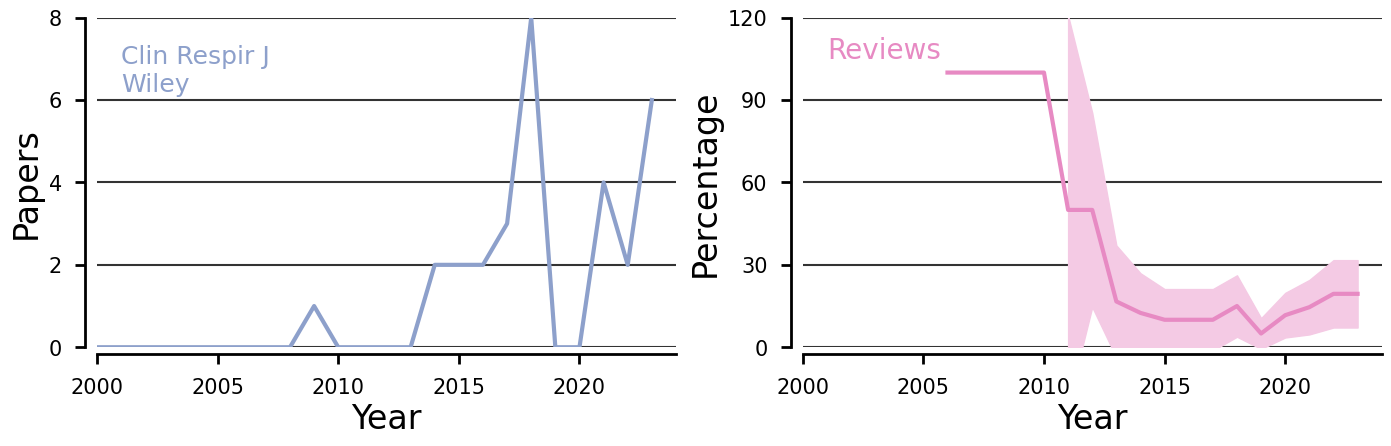

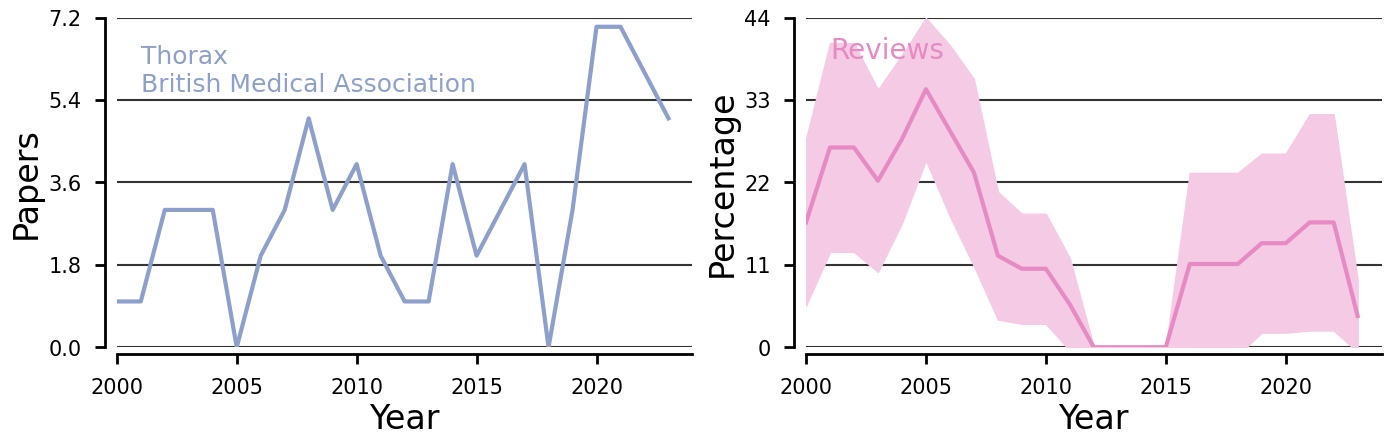

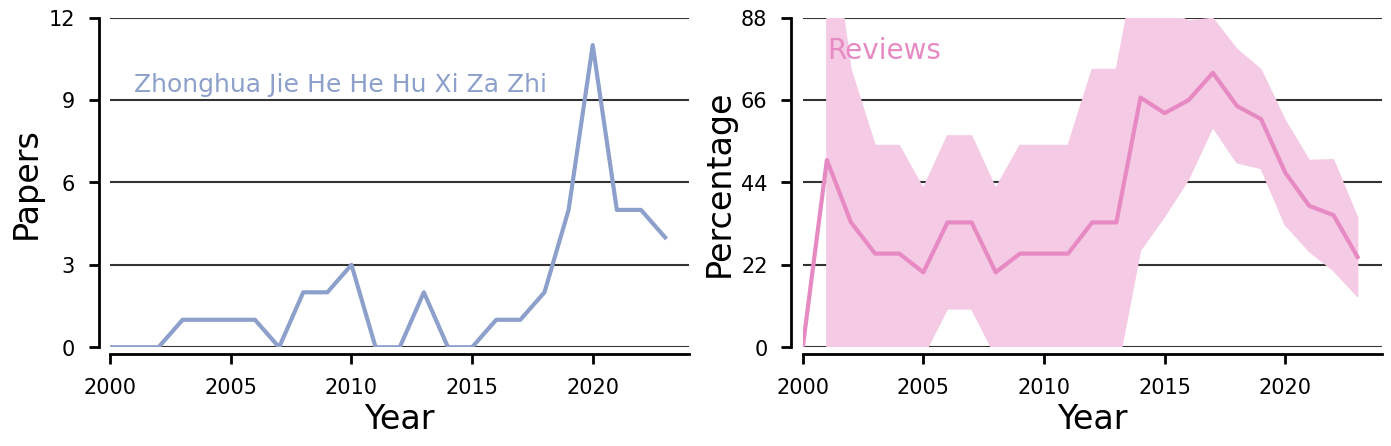

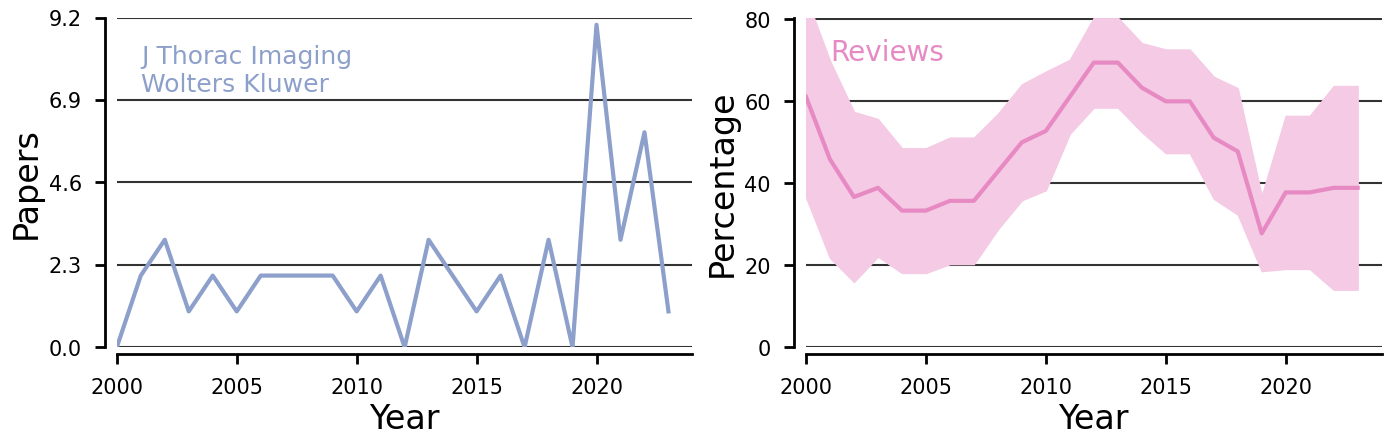

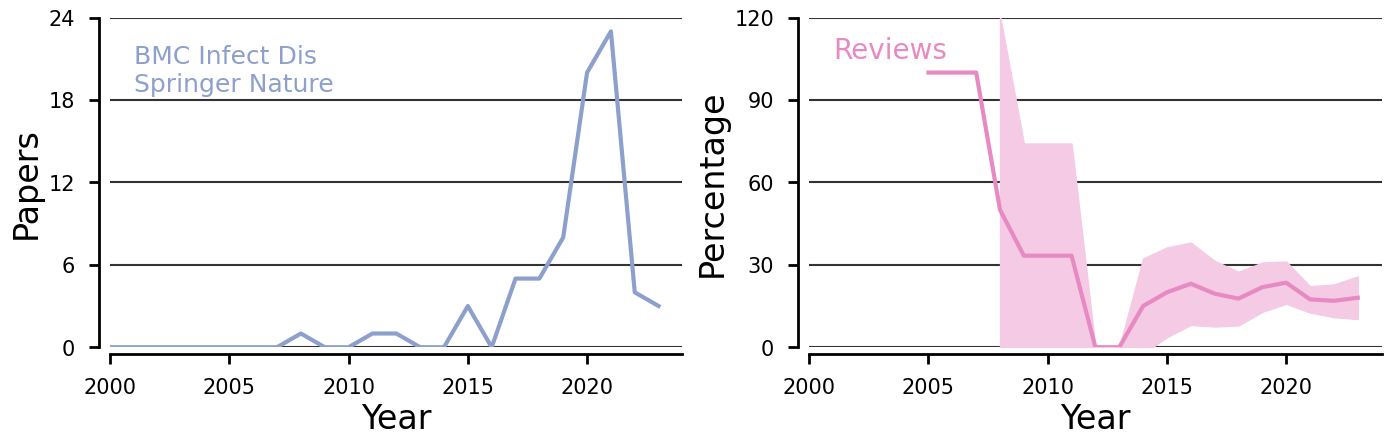

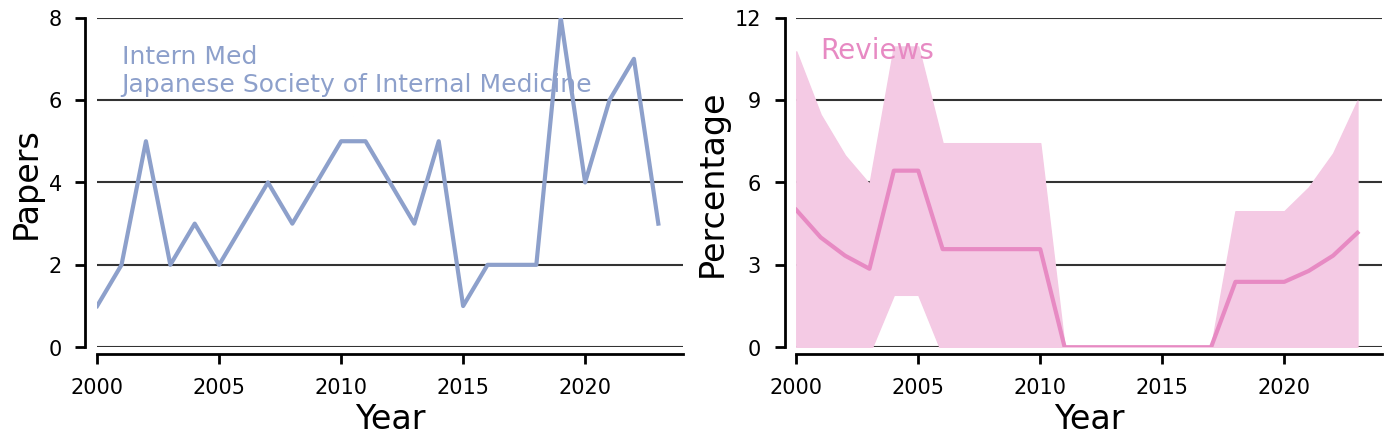

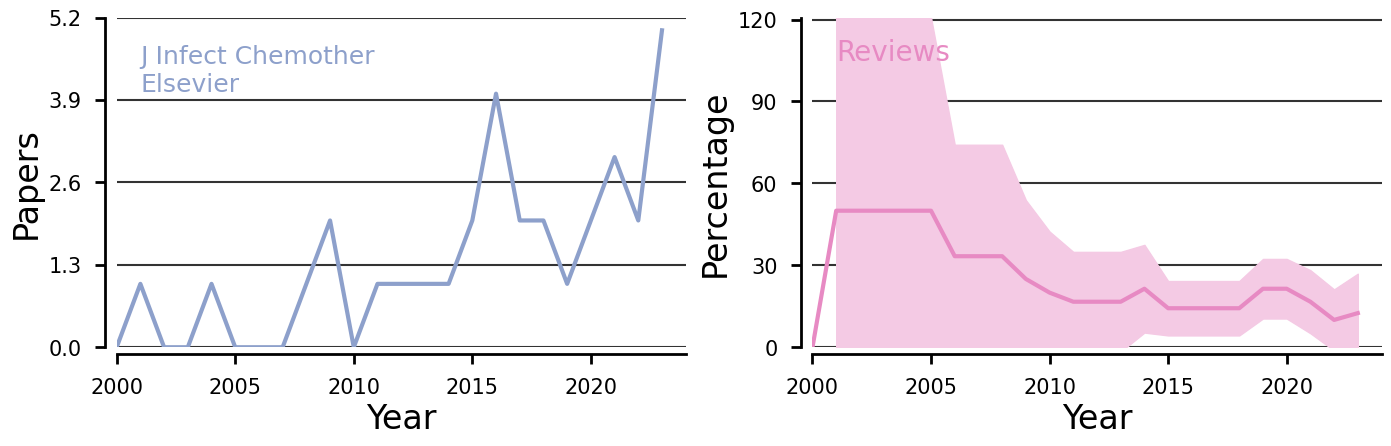

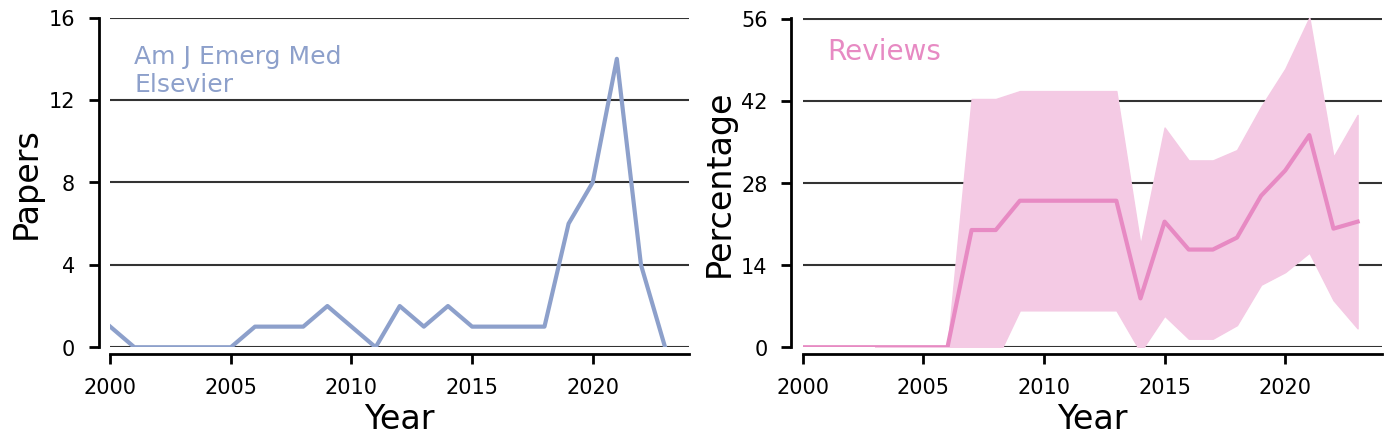

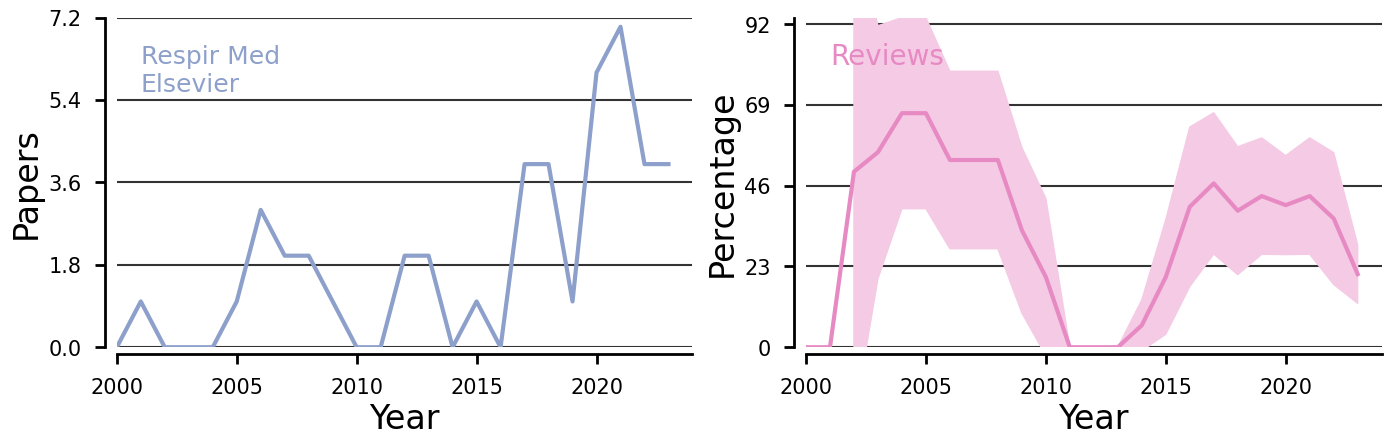

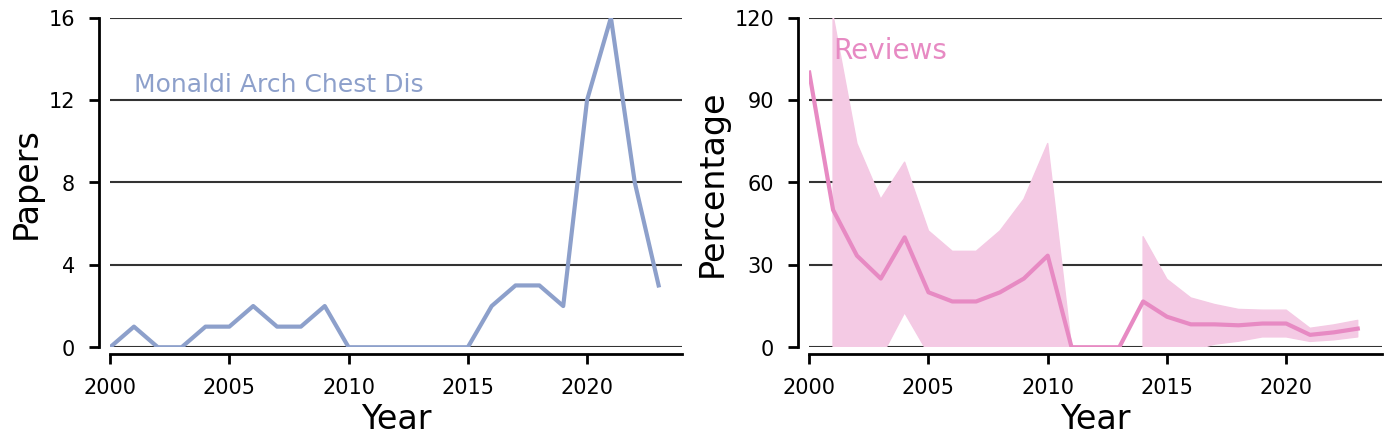

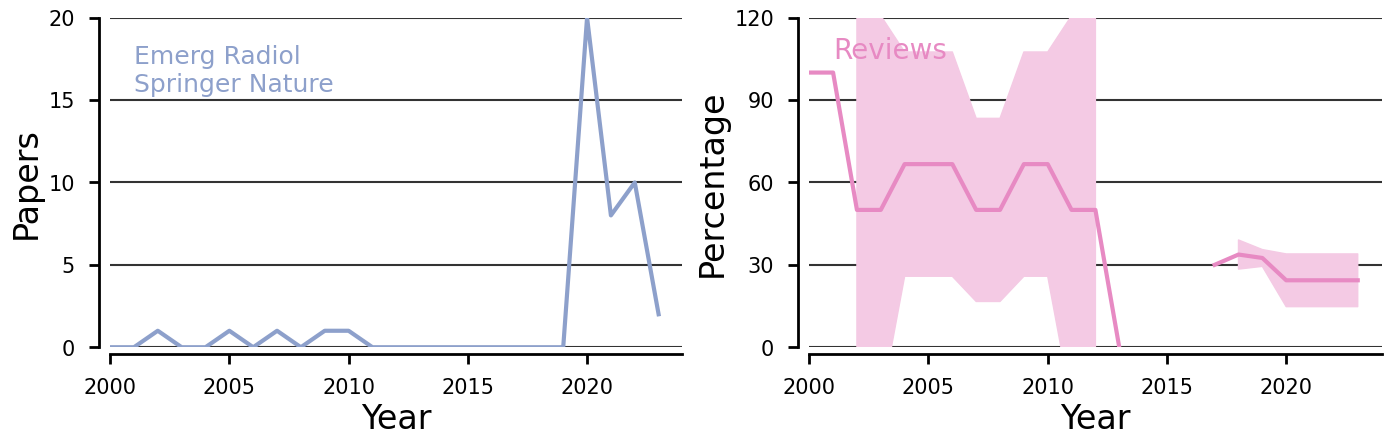

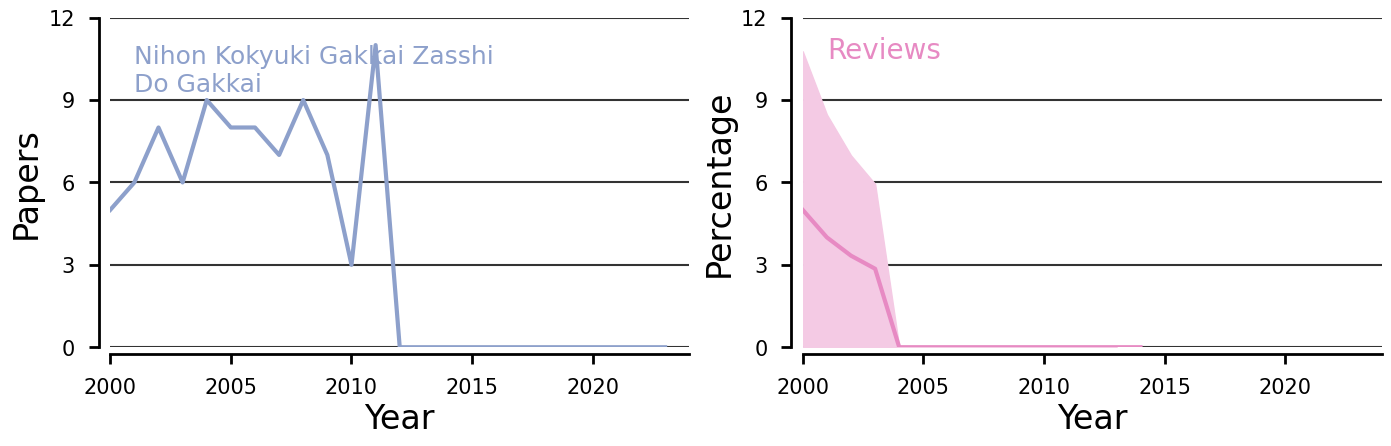

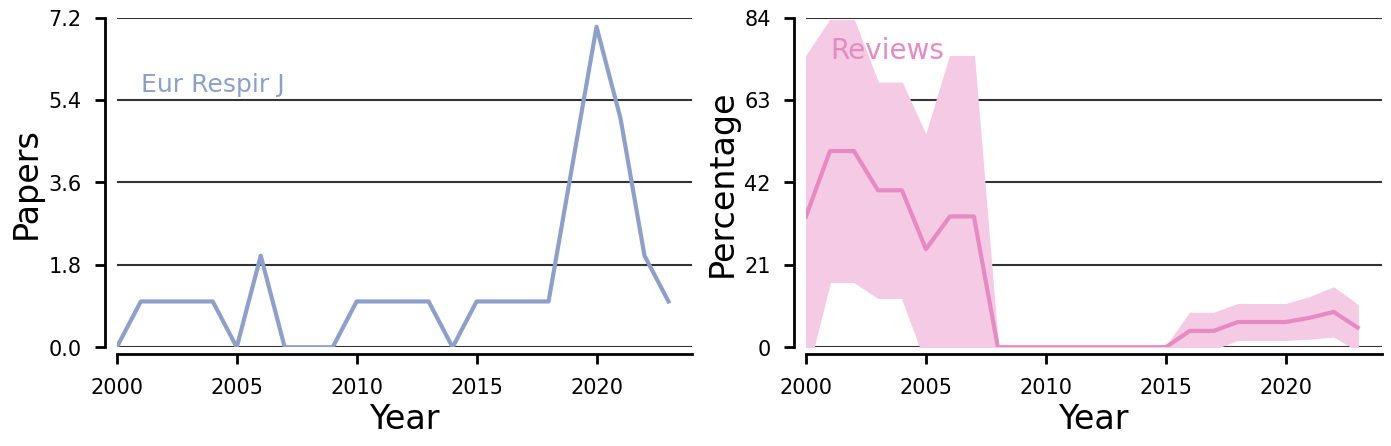

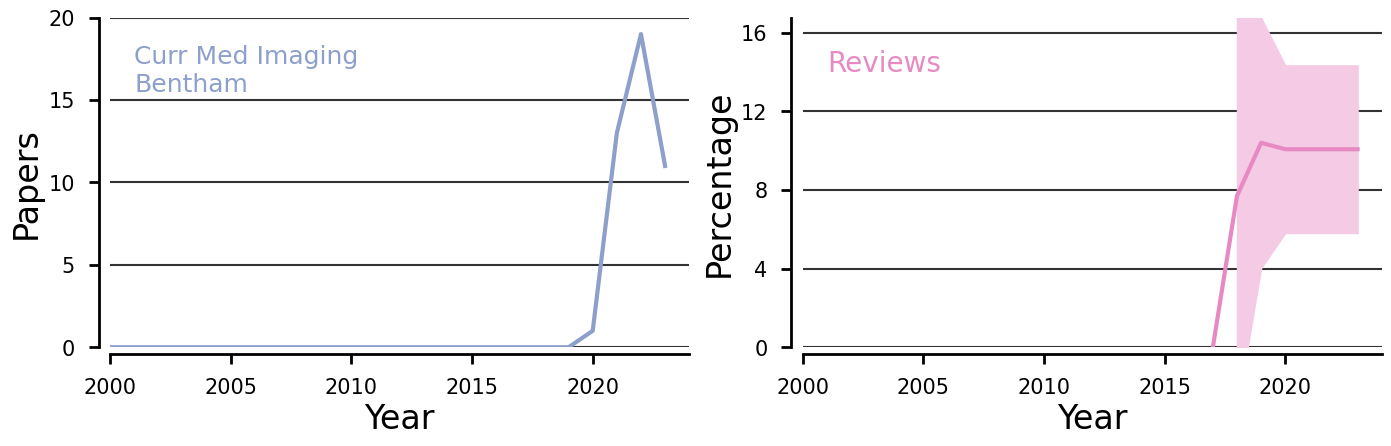

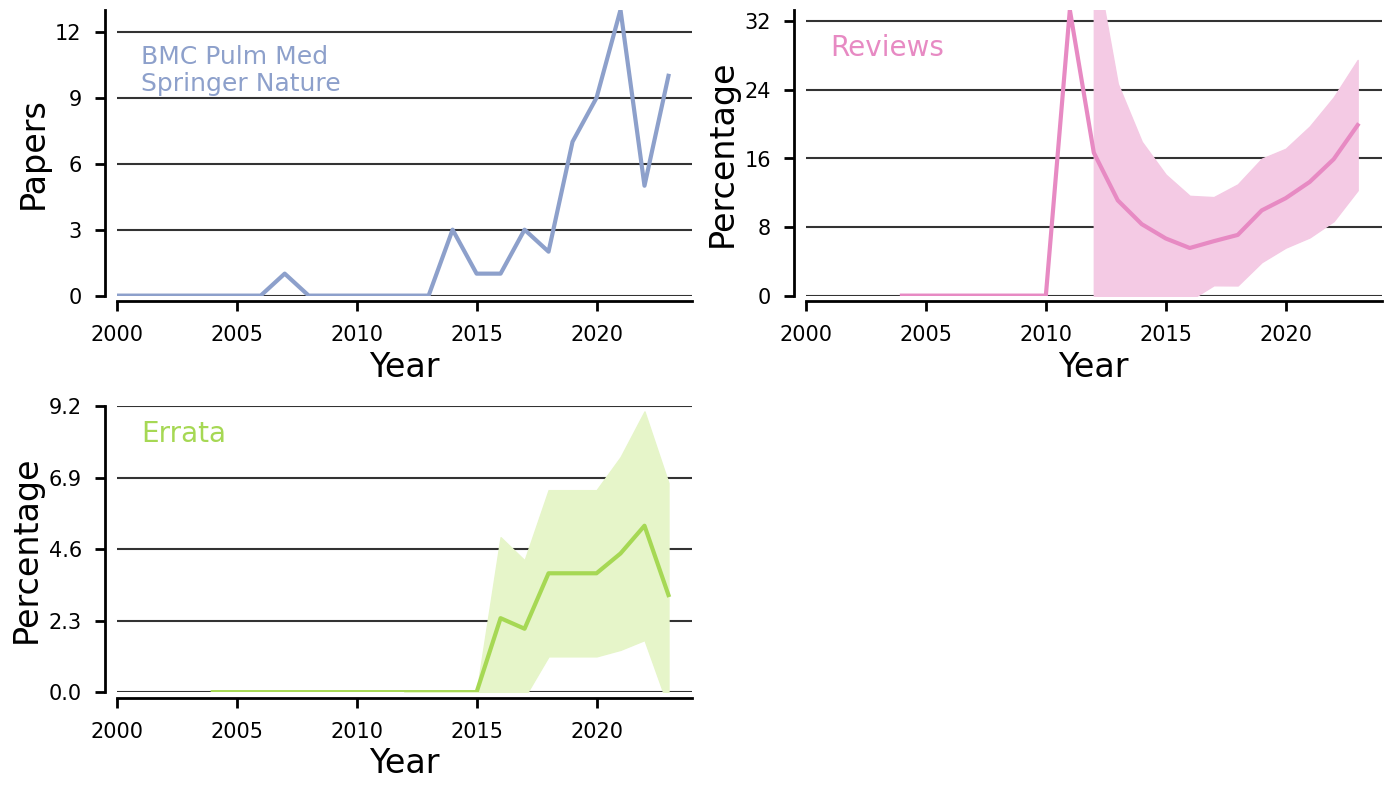

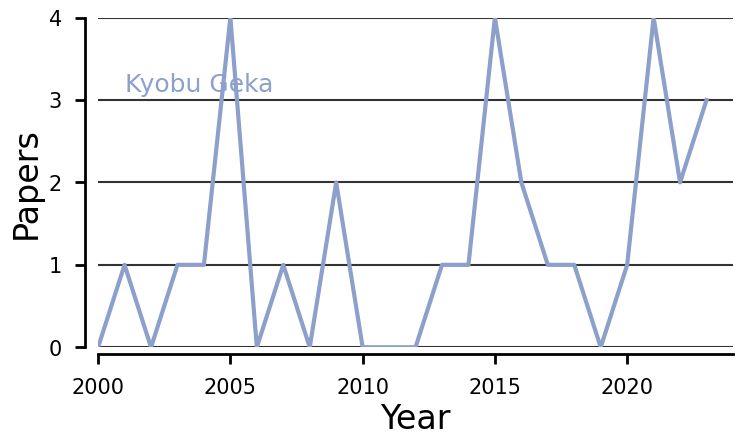

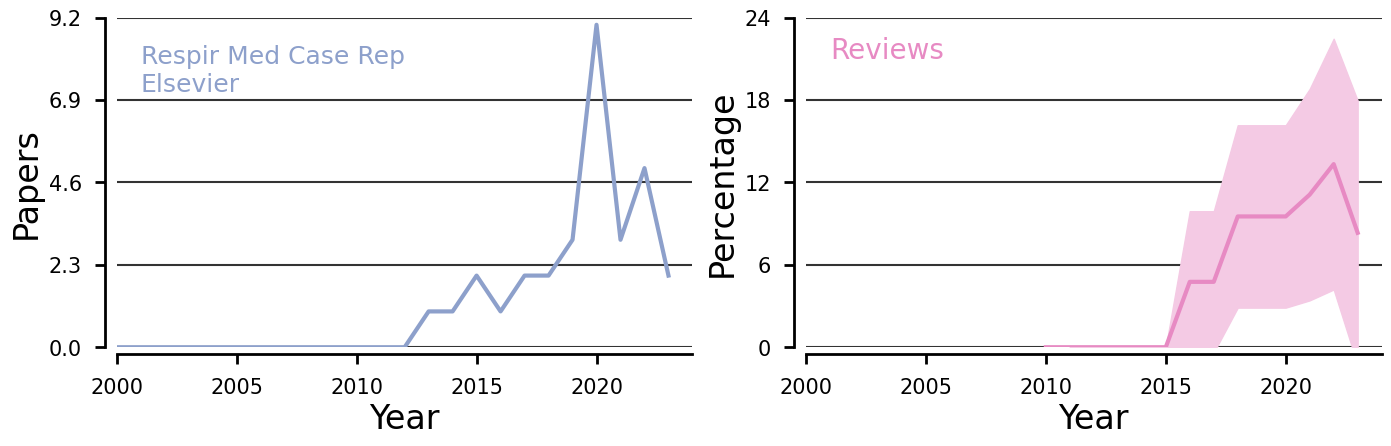

In [56]:
for journal in catalogue: 
    target_articles = []
    for article in articles:
        if article['journal'] == journal:
            target_articles.append( article )    

    if len(target_articles) < 30:
        continue
        
    print(f"\nThere are {len(target_articles)} articles in the set for "
          f"{journal}")

    pattern1 = 'review'
    pattern2 = 'reviewed'

    # Full set 
    #
    output = classify_articles( target_articles, 'FULL' )
    no_abstract_all, retracted_all, erratum_all, commented_all = output

    # Review articles set
    #
    review_articles = []
    for article in target_articles:
        if article['abstract']:
            if ( pattern1 in article['abstract'].lower() 
                 or pattern2 in article['abstract'].lower() ):
                review_articles.append( article )

    output = classify_articles( review_articles, 'REVIEW' )
    no_abstract_review, retracted_review, erratum_review, commented_review = output

    # No review articles set
    #
    no_review_articles = []
    for article in target_articles:
        if article['abstract']:
            if not ( pattern1 in article['abstract'].lower() 
                     or pattern2 in article['abstract'].lower() ):
                no_review_articles.append( article )

    output = classify_articles( no_review_articles, 'NO REVIEW' )
    no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output

    # year0, year1 = 2006, 2021
    year0, year1 = 2000, 2024
    # year0, year1 = 2010, 2024

    df_target = pd.DataFrame( {'Year': array(range(year0, year1)), 
                                'Full Set Papers': get_time_series(pd.DataFrame(target_articles), year0, year1),
                                'FS Retracted': get_time_series(pd.DataFrame(retracted_all), year0, year1), 
                                'FS Errata': get_time_series(pd.DataFrame(erratum_all), year0, year1),
                                'FS Comments': get_time_series(pd.DataFrame(commented_all), year0, year1),
                                'Review Papers': get_time_series(pd.DataFrame(review_articles), year0, year1),
                                'Rev Retracted': get_time_series(pd.DataFrame(retracted_review), year0, year1), 
                                'Rev Errata': get_time_series(pd.DataFrame(erratum_review), year0, year1),
                                'Rev Comments': get_time_series(pd.DataFrame(commented_review), year0, year1),
                                'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                                'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                                'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                                'NoRev Comments': get_time_series(pd.DataFrame(commented_norev), year0, year1),
                               } )

    key = 'Review Papers'
    column = f"{key}_ratio"
    df_target[column] = df_target[key] / df_target['Full Set Papers']

    for key in [ 'NoRev Retracted', 'NoRev Errata', 'NoRev Comments' ]:
        column = f"{key}_ratio"
        df_target[column] = df_target[key] / df_target['No Review Papers']

    colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
               'Errata': '#a6d854', 'Comments': '#66c2a5', }

    colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
                 'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

    fig = plt.figure( figsize = (14, 8) )
    ax = []


    ax.append(fig.add_subplot(221))
    if catalogue[journal] and catalogue[journal]['publisher']:
        my_label = '\n'.join([journal, catalogue[journal]['publisher']])
    else:
        my_label = journal
    plot_time_series( ax[-1], df_target, 'Full Set Papers', 1, 
                      my_label,  
                      colors['Papers'], colors_b['Papers'] )

    if df_target['Review Papers_ratio'].count() > 0:
        ax.append(fig.add_subplot(222))
        plot_time_series( ax[-1], df_target, 'Review Papers_ratio', 7, 
                          'Reviews', colors['Reviews'], 
                          colors_b['Reviews'] )

    if df_target['NoRev Retracted_ratio'].count() > 0:
        ax.append(fig.add_subplot(224))
        plot_time_series( ax[-1], df_target, 'NoRev Retracted_ratio', 7, 
                          'Retractions', colors['Retracted'], 
                          colors_b['Retracted'] )

    if df_target['NoRev Errata_ratio'].count() > 0:
        ax.append(fig.add_subplot(223))
        plot_time_series( ax[-1], df_target, 'NoRev Errata_ratio', 7, 
                          'Errata', colors['Errata'], 
                          colors_b['Errata'] )

    plt.tight_layout()
    plt.savefig(Path.cwd() / folder / 'Journals' / f"time_series_{journal}.png")

# Analyze trends by publisher


In [57]:
publisher_list = []
for journal in catalogue:
    if catalogue[journal]:
        publisher = catalogue[journal]['publisher'] 
        if publisher not in publisher_list:
            publisher_list.append(publisher )

print(publisher_list)
publisher_list.remove(None)

['Springer Nature', None, 'British Medical Association', 'Elsevier', 'IOS Press', 'Wiley', 'Wolters Kluwer', 'American Association for Cancer Research', 'Oxford University Press', 'American Medical Informatics Association', 'Future Science', 'American Medical Association', 'Taylor & Francis', 'Cold Spring Harbor Laboratory Press', 'Mary Ann Liebert', 'PLoS', 'Spandidos', 'American Society of Clinical Oncology', 'De Gruyter', 'Hindawi', 'Cambridge University Press', 'Karger', 'MDPI', 'American College of Physicians', 'Bentham', 'AAAS', 'National Academy of Sciences', 'University of Health Sciences', 'Lancet', 'Sage', 'American Medical Pub', 'Slovak Academic Press', 'Cell Press', 'CRC Press', 'IMR Press', 'Biochemical Society', 'Chinese Medical Association', 'International Institute of Anticancer Research', 'Future Science Group', 'American Public Health Association', 'American Chemical Society', 'Meditsina', 'Royal Australian College of General Practitioners', 'British Institute of Radi


There are 1 articles in the set for AAAS

There are 0 articles in the set for AIP Publ

There are 40 articles in the set for AME Publishing

There are 0 articles in the set for Academia Brasileira De Ciencias

There are 3 articles in the set for American Academy of Family Physicians

There are 2 articles in the set for American Association for Cancer Research

There are 0 articles in the set for American Association for Laboratory Animal Science

There are 0 articles in the set for American Association of Immunologists

There are 1 articles in the set for American Chemical Society

There are 3 articles in the set for American College of Physicians

There are 19 articles in the set for American Medical Association

There are 3 articles in the set for American Medical Informatics Association

There are 0 articles in the set for American Medical Pub

There are 6 articles in the set for American Physiological Society

There are 0 articles in the set for American Public Health Association



There are 135 articles in the set for PLoS
There are 135 articles in the FULL set; 0 have no abstract; 
1 have been retracted; 3 have had errata published; and 
0 have had comments written about them.


There are 22 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 1 have had errata published; and 
0 have had comments written about them.


There are 113 articles in the NO REVIEW set; 0 have no abstract; 
1 have been retracted; 2 have had errata published; and 
0 have had comments written about them.



There are 0 articles in the set for Pharmaceutical Society of Japan

There are 1 articles in the set for Pharmaceutical Society of Korea

There are 0 articles in the set for Polski Towarzystwo Farmaceutyczne

There are 1 articles in the set for Royal Australian College of General Practitioners

There are 2 articles in the set for Royal College of Surgeons of England

There are 0 articles in the set for Royal Society

There are 0 articles in the set for Royal Societ

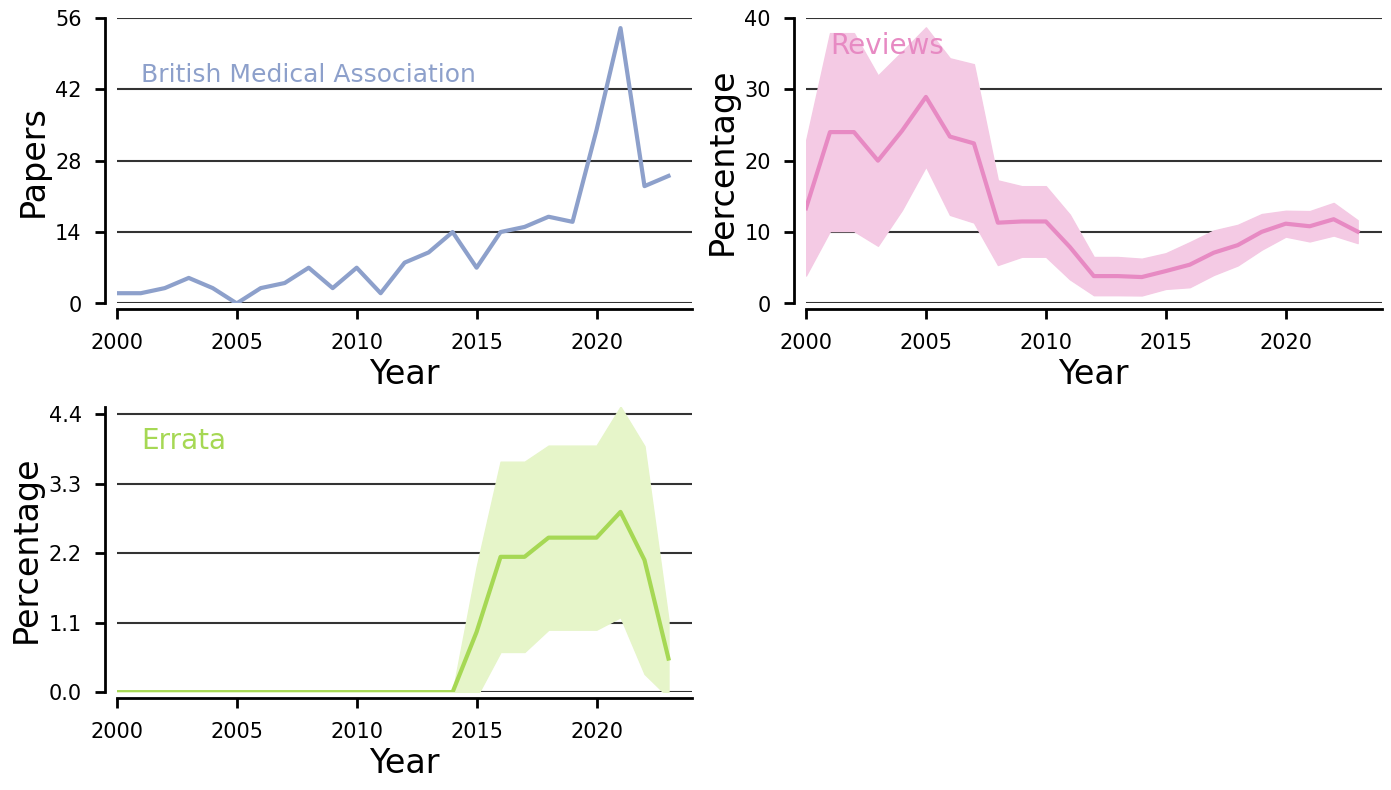

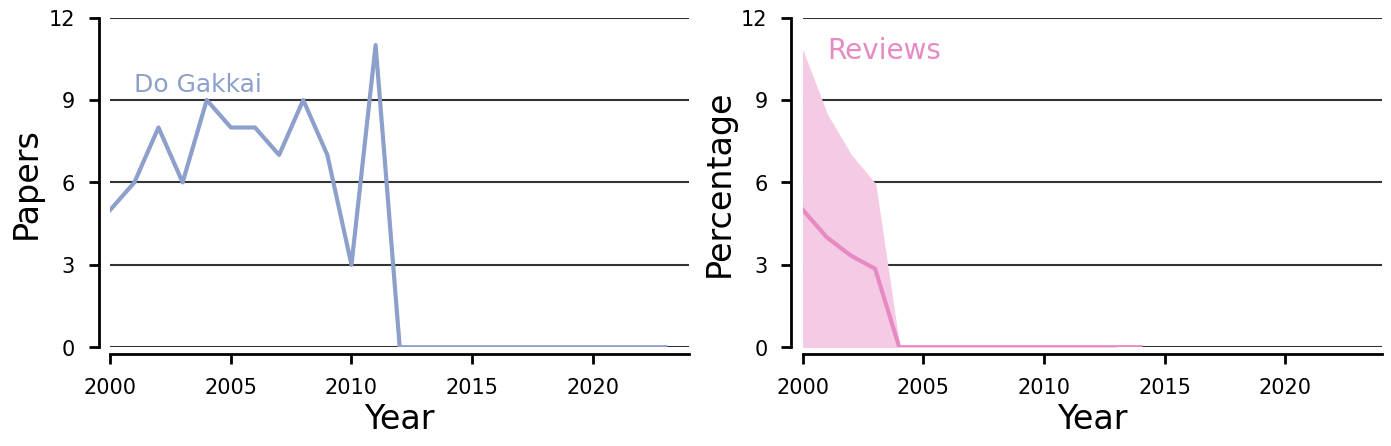

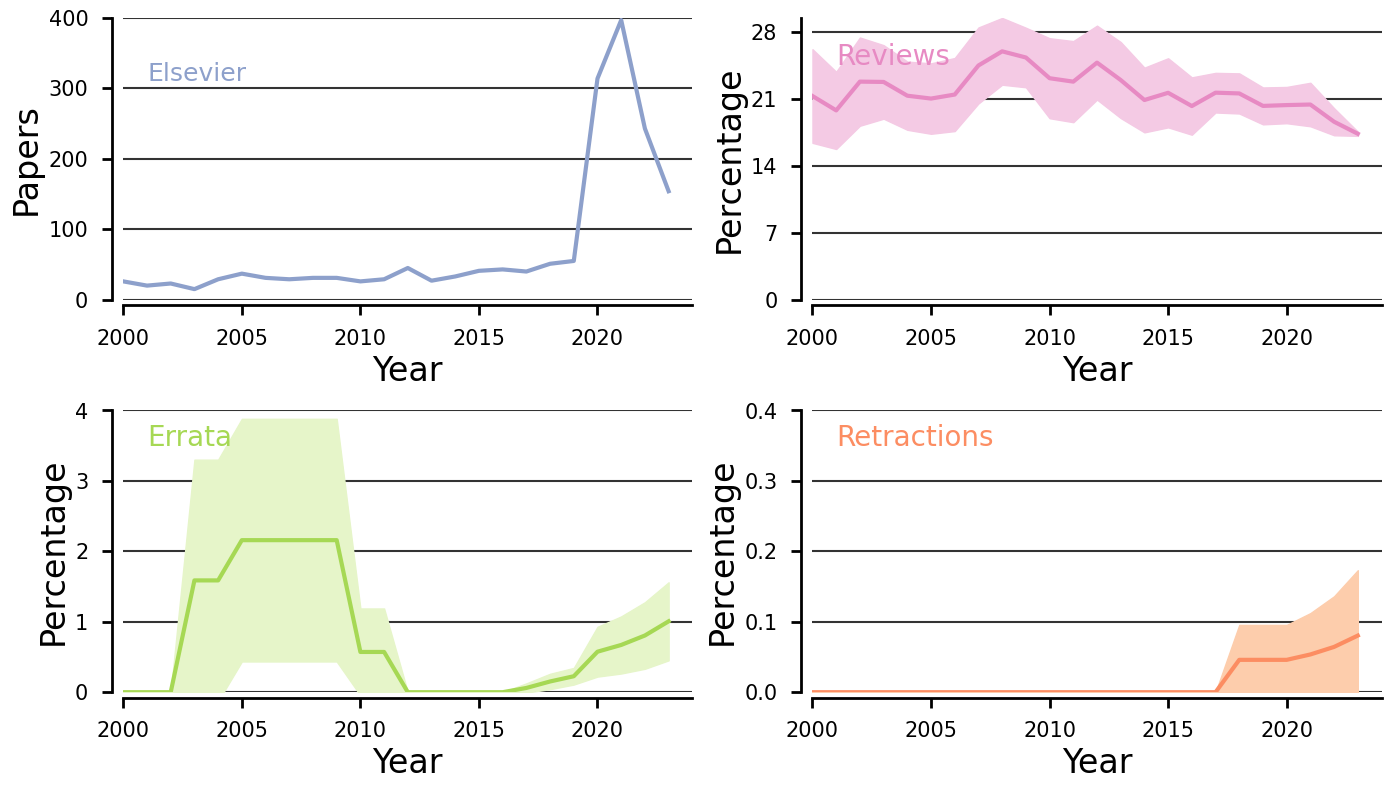

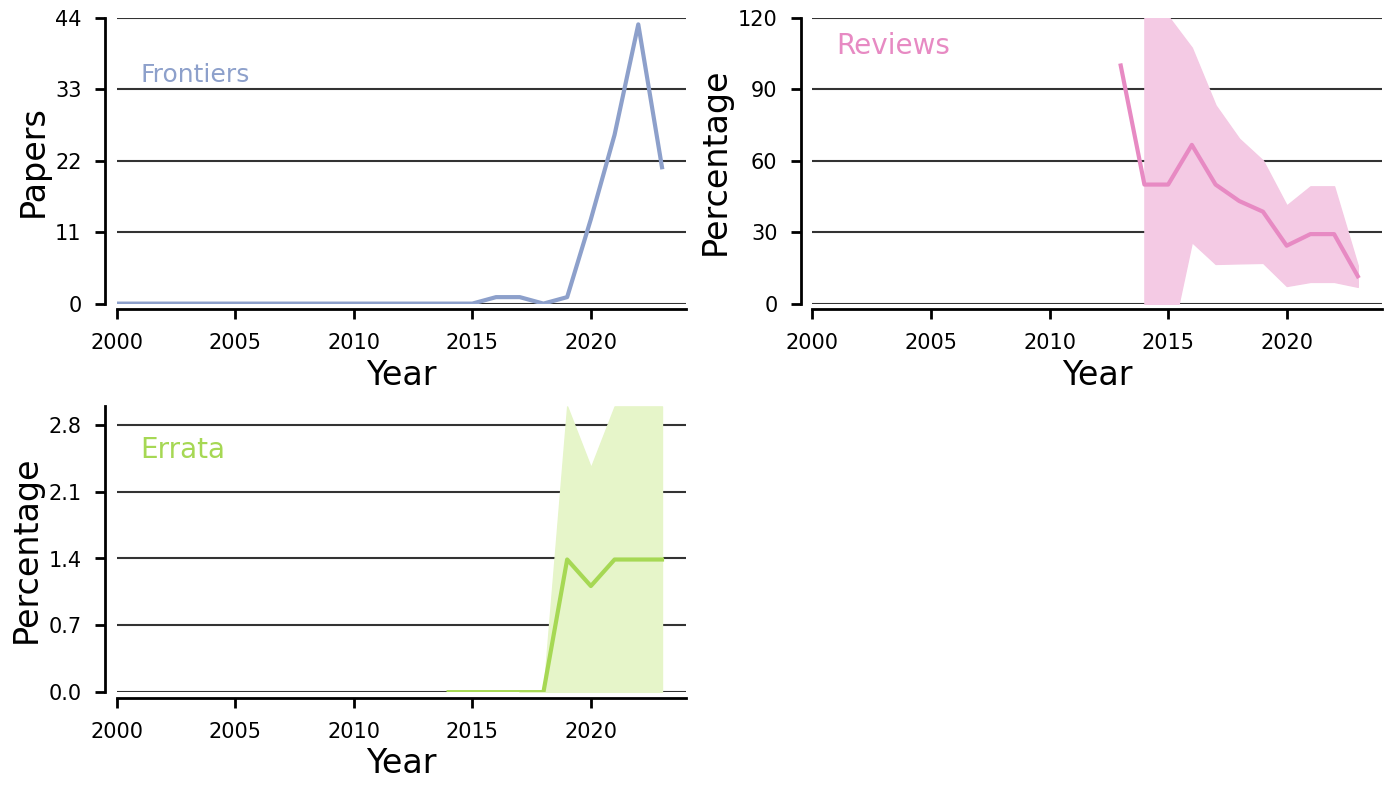

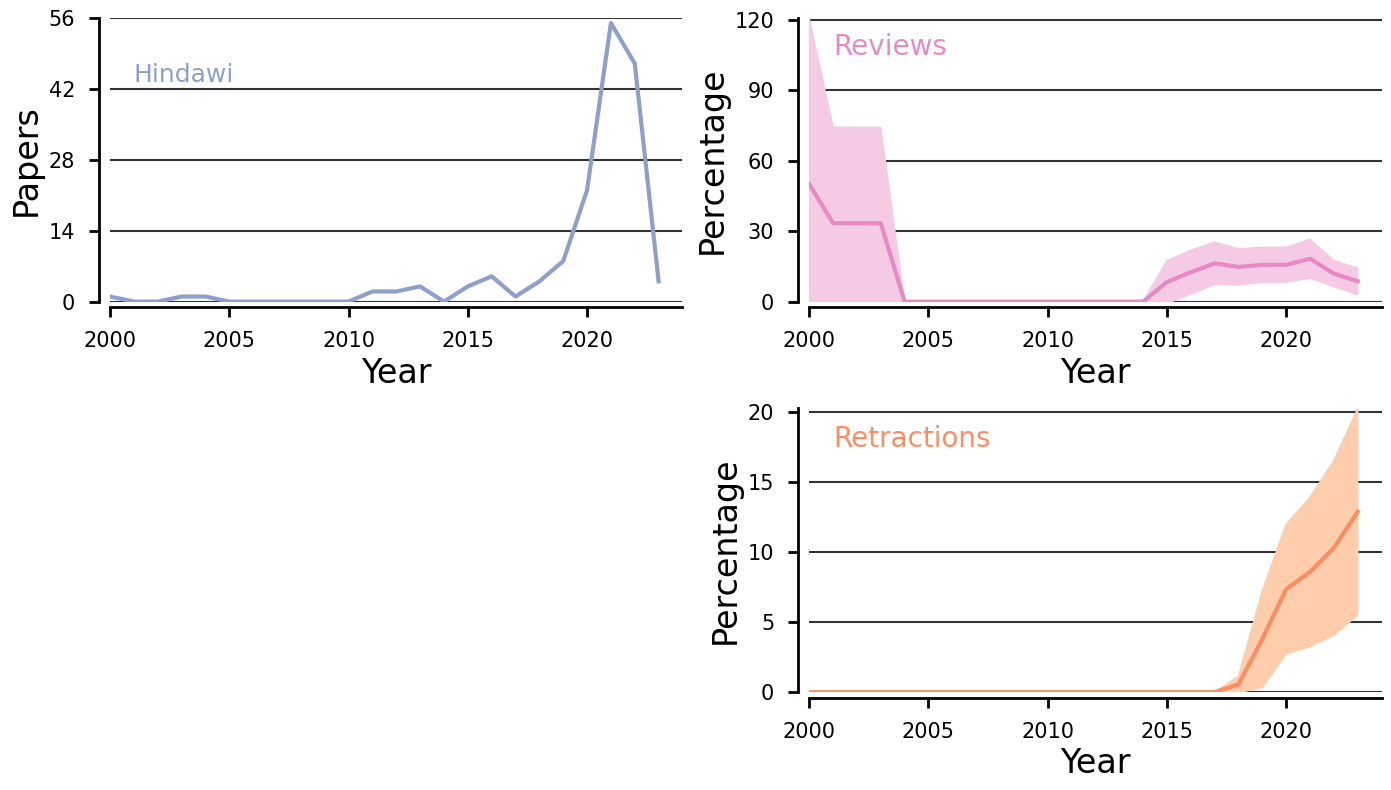

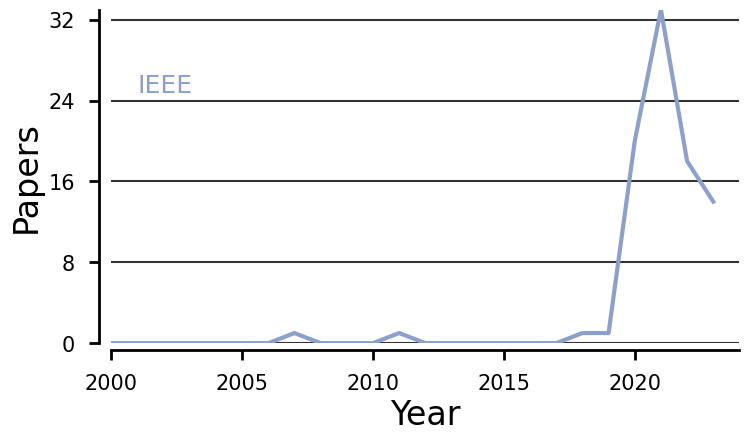

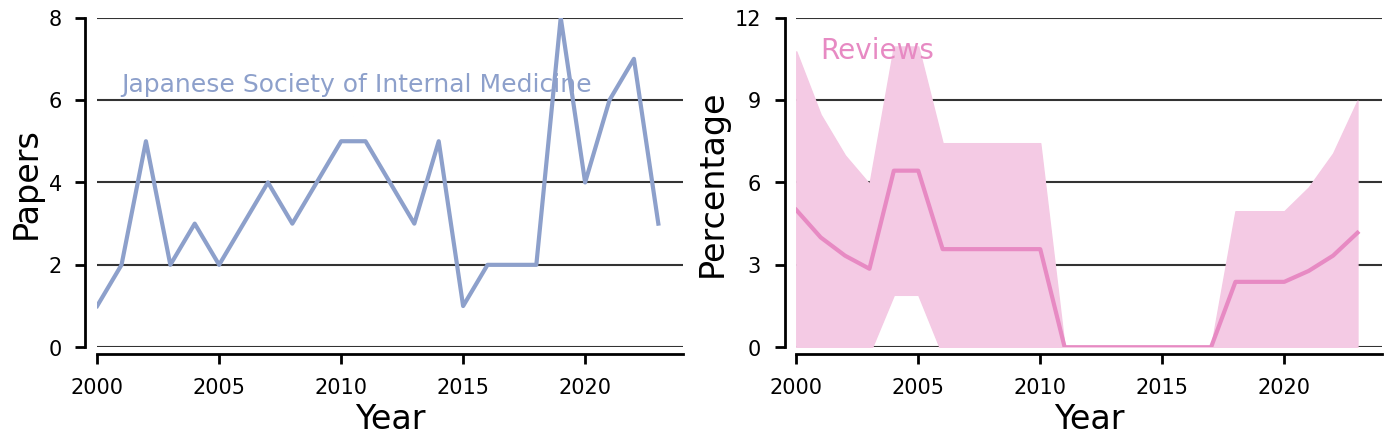

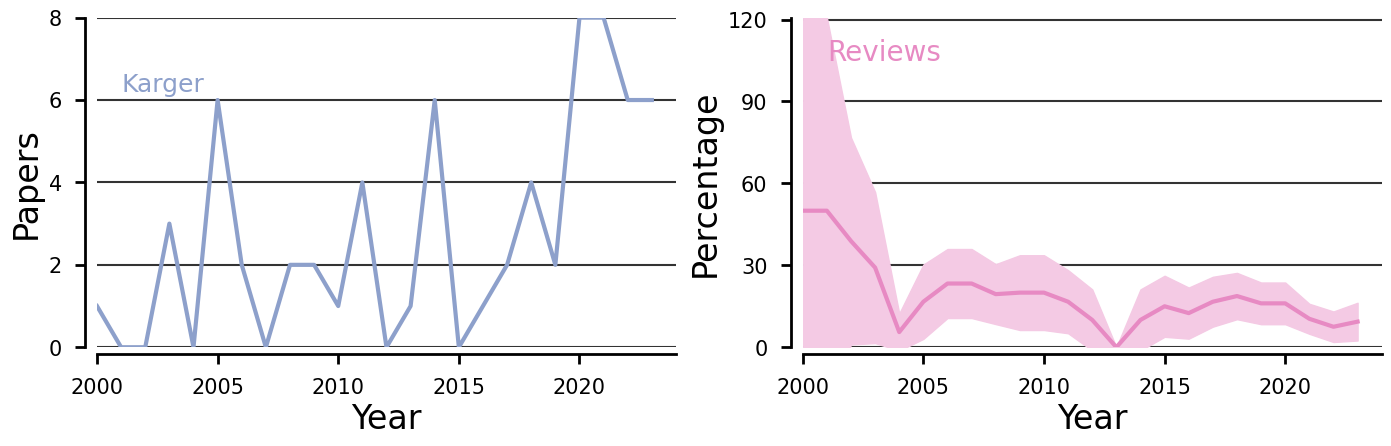

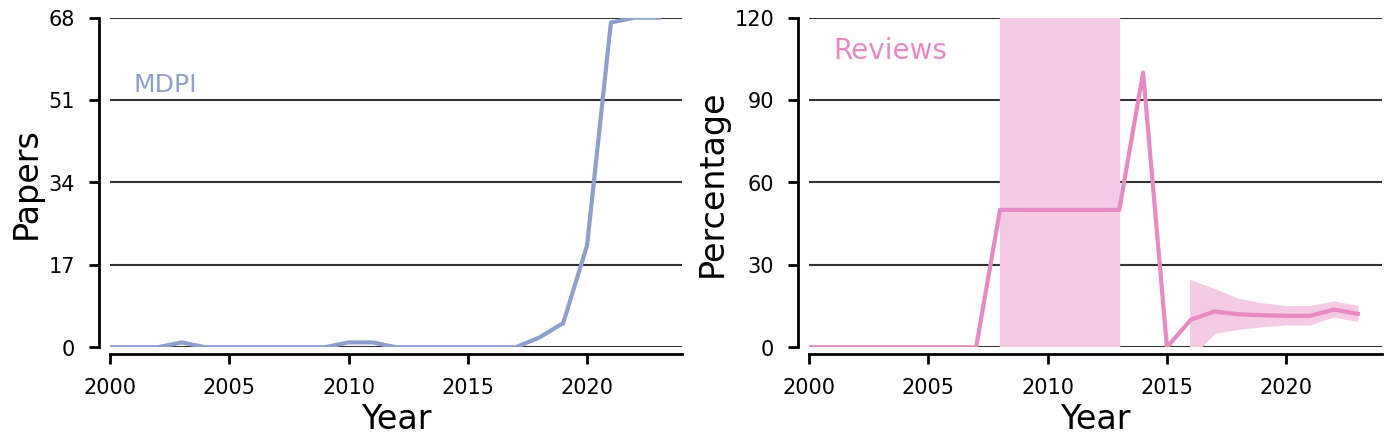

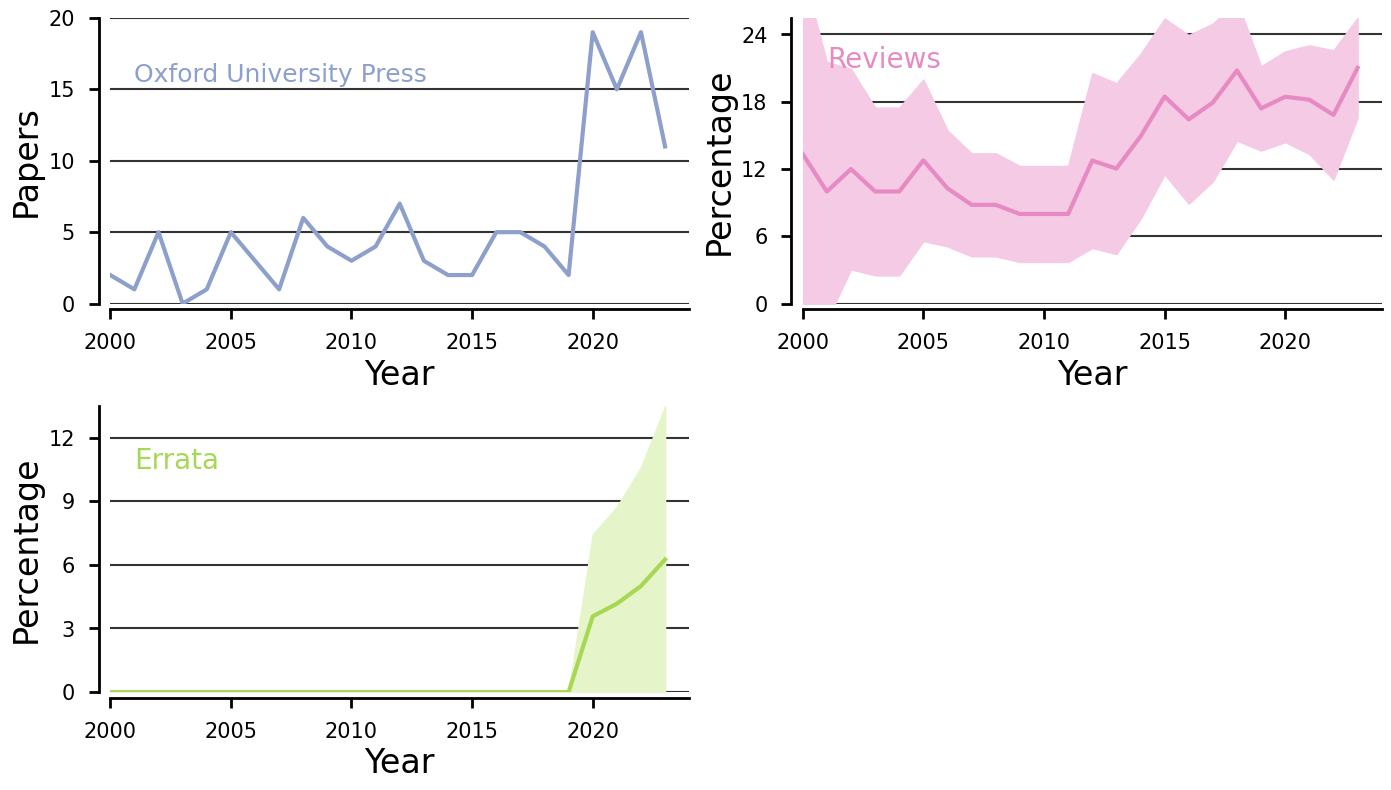

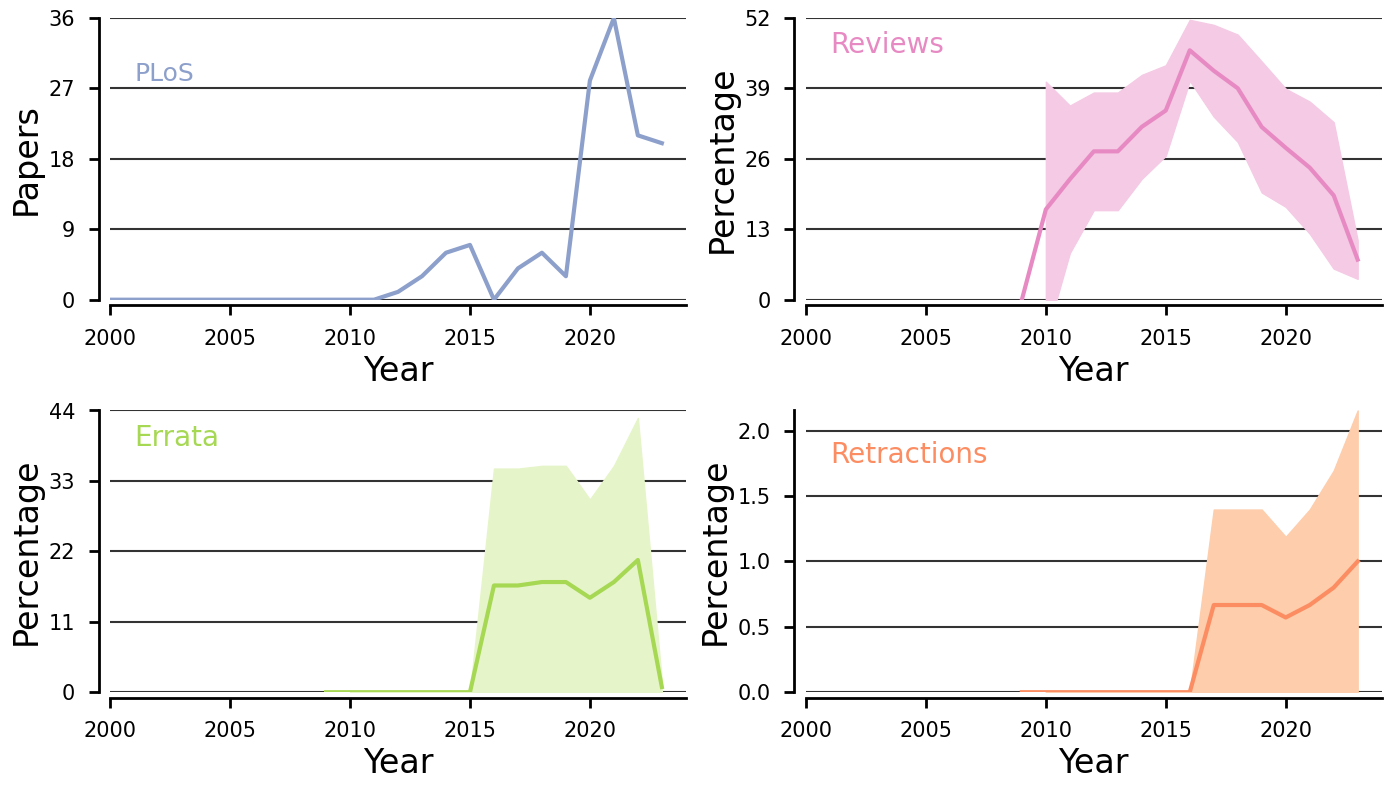

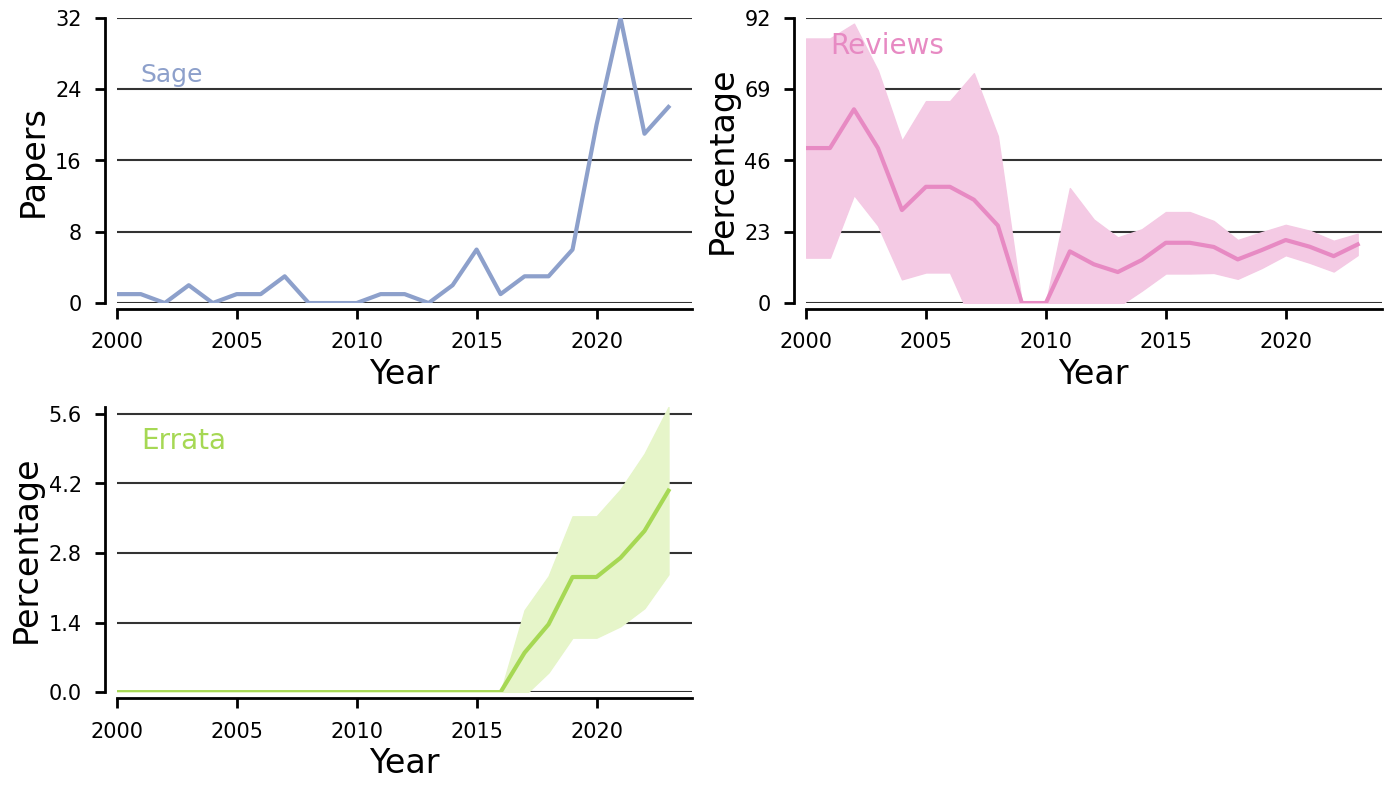

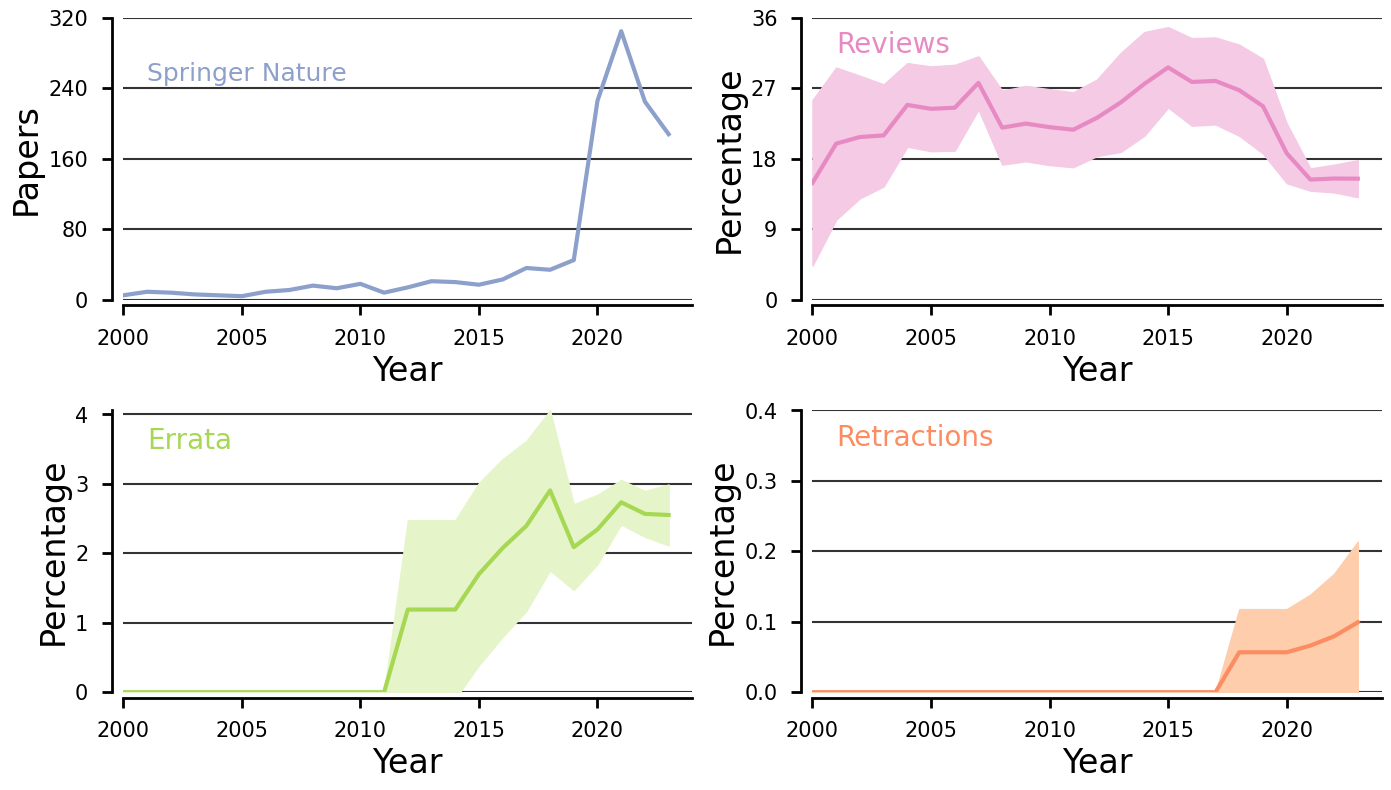

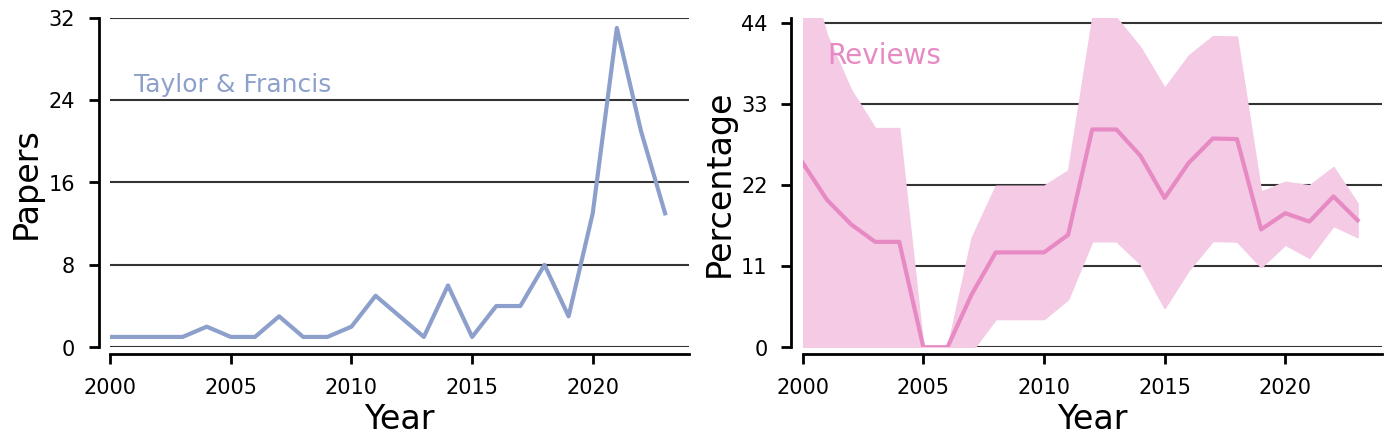

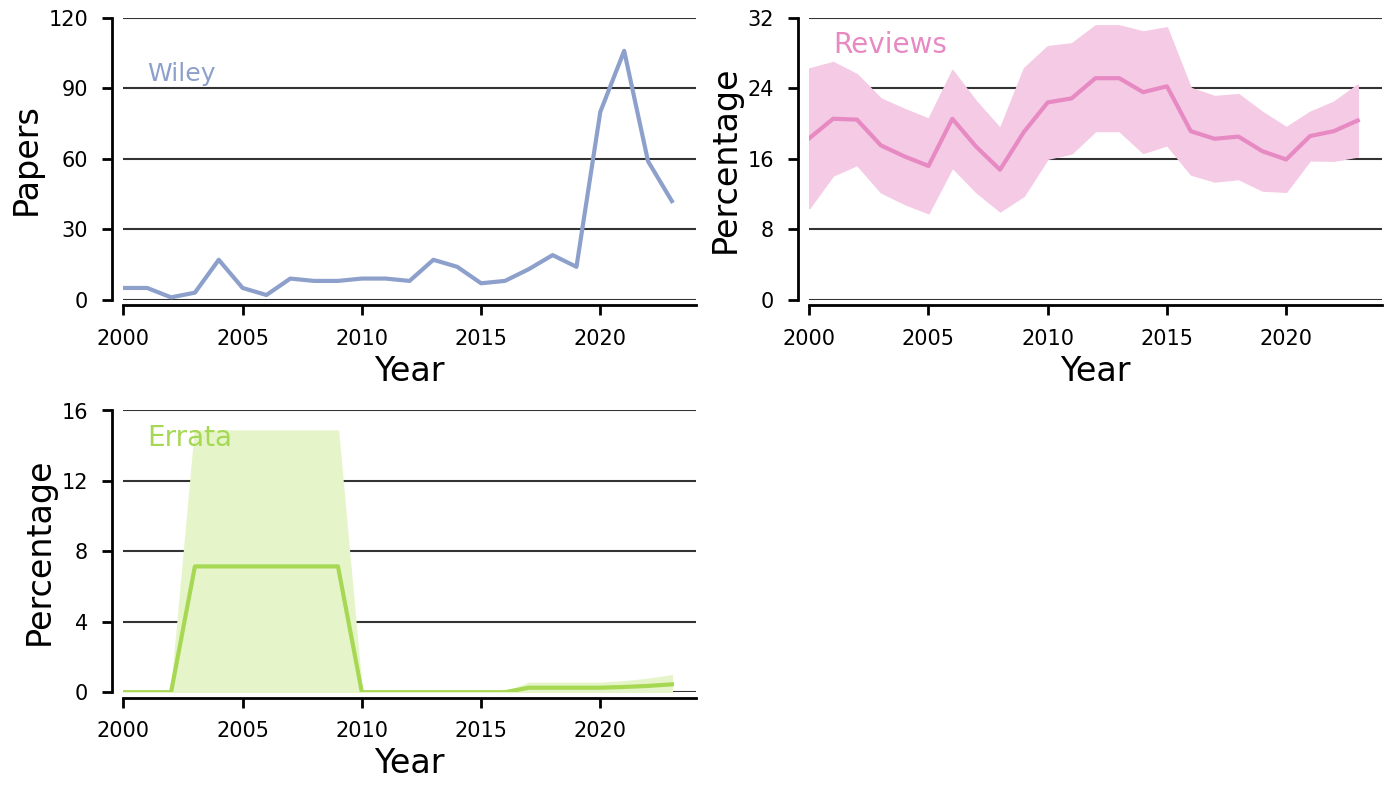

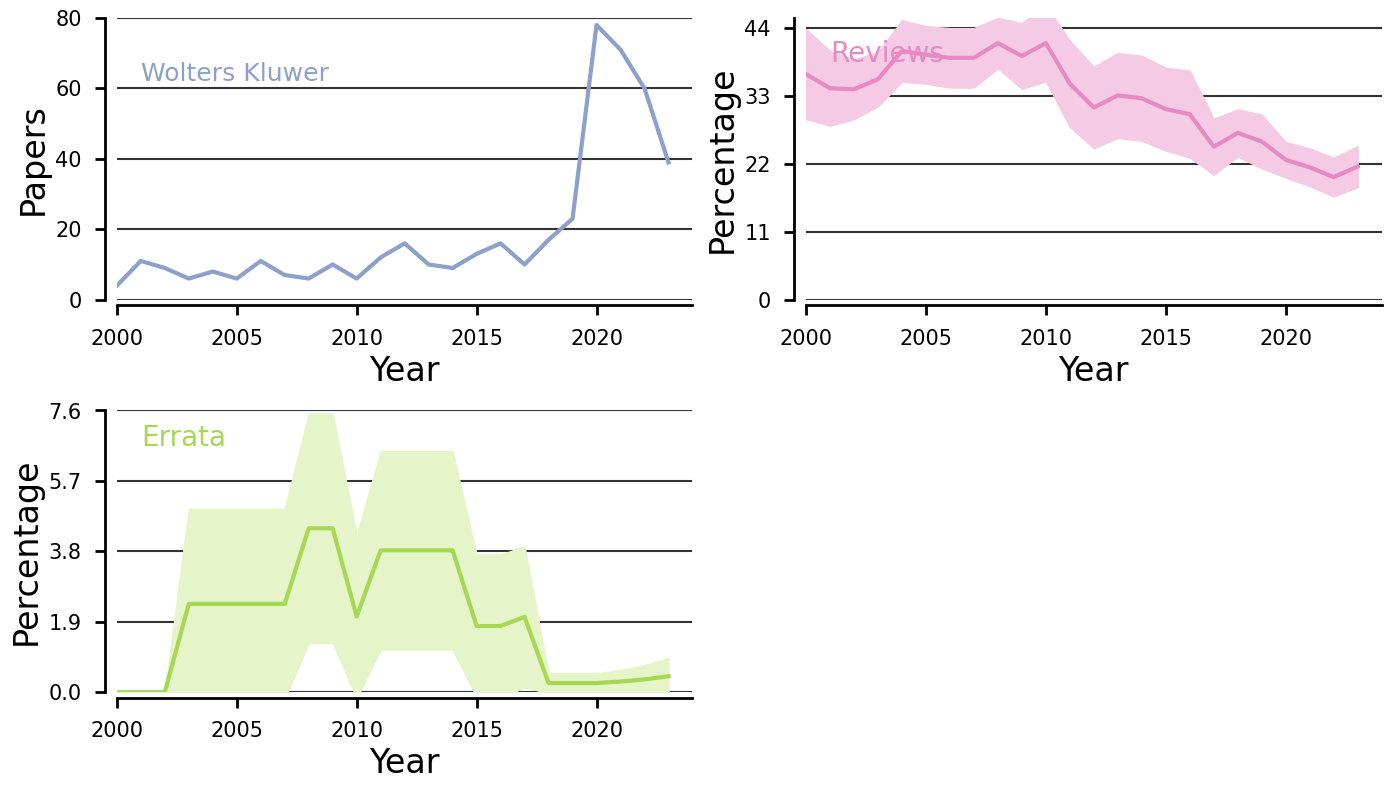

In [59]:
for publisher in sorted( publisher_list ): 
    target_articles = []
    for article in articles:
        if article['publisher']:
            if article['publisher'] == publisher:
                target_articles.append( article )

    print(f"\nThere are {len(target_articles)} articles in the set for "
          f"{publisher}")

    if len(target_articles) < 60:
        continue
        
    pattern1 = 'review'
    pattern2 = 'reviewed'

    # Full set 
    #
    output = classify_articles( target_articles, 'FULL' )
    no_abstract_all, retracted_all, erratum_all, commented_all = output

    # Review articles set
    #
    review_articles = []
    for article in target_articles:
        if article['abstract']:
            if ( pattern1 in article['abstract'].lower() 
                 or pattern2 in article['abstract'].lower() ):
                review_articles.append( article )

    output = classify_articles( review_articles, 'REVIEW' )
    no_abstract_review, retracted_review, erratum_review, commented_review = output

    # No review articles set
    #
    no_review_articles = []
    for article in target_articles:
        if article['abstract']:
            if not ( pattern1 in article['abstract'].lower() 
                     or pattern2 in article['abstract'].lower() ):
                no_review_articles.append( article )

    output = classify_articles( no_review_articles, 'NO REVIEW' )
    no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output

    # year0, year1 = 2006, 2021
    year0, year1 = 2000, 2024
    # year0, year1 = 2010, 2024

    df_target = pd.DataFrame( {'Year': array(range(year0, year1)), 
                                'Full Set Papers': get_time_series(pd.DataFrame(target_articles), year0, year1),
                                'FS Retracted': get_time_series(pd.DataFrame(retracted_all), year0, year1), 
                                'FS Errata': get_time_series(pd.DataFrame(erratum_all), year0, year1),
                                'FS Comments': get_time_series(pd.DataFrame(commented_all), year0, year1),
                                'Review Papers': get_time_series(pd.DataFrame(review_articles), year0, year1),
                                'Rev Retracted': get_time_series(pd.DataFrame(retracted_review), year0, year1), 
                                'Rev Errata': get_time_series(pd.DataFrame(erratum_review), year0, year1),
                                'Rev Comments': get_time_series(pd.DataFrame(commented_review), year0, year1),
                                'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                                'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                                'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                                'NoRev Comments': get_time_series(pd.DataFrame(commented_norev), year0, year1),
                               } )

    key = 'Review Papers'
    column = f"{key}_ratio"
    df_target[column] = df_target[key] / df_target['Full Set Papers']

    for key in [ 'NoRev Retracted', 'NoRev Errata', 'NoRev Comments' ]:
        column = f"{key}_ratio"
        df_target[column] = df_target[key] / df_target['No Review Papers']

    colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
               'Errata': '#a6d854', 'Comments': '#66c2a5', }

    colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
                 'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

    fig = plt.figure( figsize = (14, 8) )
    ax = []


    ax.append(fig.add_subplot(221))
    plot_time_series( ax[-1], df_target, 'Full Set Papers', 1, 
                      publisher,
                      colors['Papers'], colors_b['Papers'] )

    if df_target['Review Papers_ratio'].count() > 0:
        ax.append(fig.add_subplot(222))
        plot_time_series( ax[-1], df_target, 'Review Papers_ratio', 7, 
                          'Reviews', colors['Reviews'], 
                          colors_b['Reviews'] )

    if df_target['NoRev Retracted_ratio'].count() > 0:
        ax.append(fig.add_subplot(224))
        plot_time_series( ax[-1], df_target, 'NoRev Retracted_ratio', 7, 
                          'Retractions', colors['Retracted'], 
                          colors_b['Retracted'] )

    if df_target['NoRev Errata_ratio'].count() > 0:
        ax.append(fig.add_subplot(223))
        plot_time_series( ax[-1], df_target, 'NoRev Errata_ratio', 7, 
                          'Errata', colors['Errata'], 
                          colors_b['Errata'] )

    plt.tight_layout()
    plt.savefig(Path.cwd() / folder / 'Publishers' / f"time_series_{publisher}.png")

# Analyze trends relating to publisher type

In [ ]:
target_publishers = [ 'Frontiers', 'Hindawi', 'IOS Press', 
                      'Mary Ann Liebert', 'MDPI', ]

In [ ]:
target_publishers = [ 'American Association for Cancer Research', 
                      'American Medical Association', 
                      'American Chemical Society', 
                      'Cell Press', 'Elsevier', 'FASEB', 'Nature Springer',
                      'Oxford University Press', 
                      'Nature Springer', 
                      'PLoS', 'Royal Society of Chemistry',
                      'Taylor & Francis', ]

# 'Wiley' for skin
# Nature Springer and 'Oxford University Press' dramatically increase
# fraction of reviews over the period for BRAC2


In [ ]:
target_publishers = ['American Society of Clinical Oncology']

In [ ]:
target_code = str(target_publishers).replace(', ', '_').replace("'", '').strip('[]')
print(target_code)

target_articles = []
for article in articles:
    if article['publisher']:
        if article['publisher'] in target_publishers:
            target_articles.append( article )    

print(f"\nThere are {len(target_articles)} articles in the set for "
      f"publishers:\n\t{target_code}")

In [ ]:
pattern1 = 'review'
pattern2 = 'reviewed'

# Full set 
#
output = classify_articles( target_articles, 'FULL' )
no_abstract_all, retracted_all, erratum_all, commented_all = output

# Review articles set
#
review_articles = []
for article in target_articles:
    if article['abstract']:
        if ( pattern1 in article['abstract'].lower() 
             or pattern2 in article['abstract'].lower() ):
            review_articles.append( article )

output = classify_articles( review_articles, 'REVIEW' )
no_abstract_review, retracted_review, erratum_review, commented_review = output

# No review articles set
#
no_review_articles = []
for article in target_articles:
    if article['abstract']:
        if not ( pattern1 in article['abstract'].lower() 
                 or pattern2 in article['abstract'].lower() ):
            no_review_articles.append( article )

output = classify_articles( no_review_articles, 'NO REVIEW' )
no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output

## Create dataframe with time series 

In [ ]:
# year0, year1 = 2006, 2021
year0, year1 = 2000, 2024
# year0, year1 = 2010, 2024

df_target = pd.DataFrame( {'Year': array(range(year0, year1)), 
                            'Full Set Papers': get_time_series(pd.DataFrame(target_articles), year0, year1),
                            'FS Retracted': get_time_series(pd.DataFrame(retracted_all), year0, year1), 
                            'FS Errata': get_time_series(pd.DataFrame(erratum_all), year0, year1),
                            'FS Comments': get_time_series(pd.DataFrame(commented_all), year0, year1),
                            'Review Papers': get_time_series(pd.DataFrame(review_articles), year0, year1),
                            'Rev Retracted': get_time_series(pd.DataFrame(retracted_review), year0, year1), 
                            'Rev Errata': get_time_series(pd.DataFrame(erratum_review), year0, year1),
                            'Rev Comments': get_time_series(pd.DataFrame(commented_review), year0, year1),
                            'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                            'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                            'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                            'NoRev Comments': get_time_series(pd.DataFrame(commented_norev), year0, year1),
                           } )

df_target



## Calculate ratios

In [ ]:
key = 'Review Papers'
column = f"{key}_ratio"
df_target[column] = df_target[key] / df_target['Full Set Papers']
    
for key in [ 'NoRev Retracted', 'NoRev Errata', 'NoRev Comments' ]:
    column = f"{key}_ratio"
    df_target[column] = df_target[key] / df_target['No Review Papers']


## Plot data

In [ ]:
colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
           'Errata': '#a6d854', 'Comments': '#66c2a5', }

colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
             'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

fig = plt.figure( figsize = (14, 8) )
ax = []

ax.append(fig.add_subplot(221))
plot_time_series( ax[-1], df_target, 'Full Set Papers', 1, 
                         folder.replace('_', ' '), colors['Papers'], 
                         colors_b['Papers'] )
# ax[-1].semilogy()

ax.append(fig.add_subplot(222))
plot_time_series( ax[-1], df_target, 'NoRev Retracted_ratio', 7, 
                        'Retractions', colors['Retracted'], 
                        colors_b['Retracted'] )

ax.append(fig.add_subplot(223))
plot_time_series( ax[-1], df_target, 'Review Papers_ratio', 7, 
                        'Reviews', colors['Reviews'], 
                        colors_b['Reviews'] )
# ax[-1].semilogy()

ax.append(fig.add_subplot(224))
# plot_time_series( ax[-1], df_target, 'NoRev Comments_ratio', 5, 
#                          'Comments', colors['Comments'], 
#                         colors_b['Comments'] )

plot_time_series( ax[-1], df_target, 'NoRev Errata_ratio', 7, 
                        'Errata', colors['Errata'], 
                        colors_b['Errata'] )

plt.tight_layout()

plt.savefig(Path.cwd() / folder / f"time_series_{target_code}.png")